## Import packages

In [1]:
import numpy as np
import numpy_financial as npf
import pandas as pd
import time
import pyomo.environ as pe
from pyomo.gdp import Disjunct, Disjunction
from pyomo.environ import ConstraintList, Block

## Model construction

### Creation of a Concrete Model

In [2]:
model = pe.ConcreteModel()

###  Define sets

#### Products

In [3]:
FEEDSTOCKS = ['hardwood', 'softwood', 'herbaceous-plant']
POLYMERS = ['cellulose','hemicellulose','lignin1']
PRODUCT1 = ['glucose','xylose','furfural','lignin2']
PRODUCT2 = ['lignin-monomers','char','unconverted-lignin']
PRODUCT3 = ['PHA','glycerol','methyl-oleate','adipic-acid','PDC']
FINALPRODUCT = ['PHA','methyl-oleate','adipic-acid','PDC']
BYPRODUCT = ['glucose','xylose','furfural','char','glycerol']
ALL_PRODUCT = FEEDSTOCKS + POLYMERS + PRODUCT1 + PRODUCT2 + PRODUCT3

#### Processes

In [4]:
MILLING = ['milling']
FRACTIONATION = ['DSA','SEP','LHW','organosolv','AFEX','GVL','alkaline']
DEPOLYMERIZATION = ['BCD','pyrolysis','HDO','HyThUp','HYDRO','noprocess']
UPGRADING = ['PHA-ferm', 'lipid-ferm_biodiesel-prod', 'MA-ferm_AA-prod','PDC-ferm']
ALL_PROCESS = MILLING + FRACTIONATION + DEPOLYMERIZATION + UPGRADING

#### Chemicals and utility

| |  | |
|  :----  | :----  |:----  |
|  ch  | chemicals  |water,NaOH,H2SO4,cellulase-enzymes,EtOH,anthraquinone,H2,CSL,DAP,methanol,chloroform,H3PO4  |
|  ut  | utility  |cooling-water,electricity,natural-gas  |

In [5]:
CHEMICALS = ['water','NaOH','H2SO4','NH3','EtOH','anthraquinone','H2','cellulase-enzymes','CSL','DAP',
             'methanol','chloroform','H3PO4','GVL','glucose','AS','DSP','MPP','boiler_chem','FGD']
UTILITY =['cooling-water','electricity','natural-gas']

### Define parameters

#### Maximum input (ton/day)

In [6]:
max_inflow = 2000

#### Scaling coefficient

In [7]:
scal = 0.6

#### Feedstock composition

In [8]:
composition = pd.DataFrame(index = FEEDSTOCKS)

composition['cellulose'] = [0.46,0.38,0.49]
composition['hemicellulose'] = [0.28,0.32,0.36]
composition['lignin1'] = [0.26,0.3,0.15]

composition

cellulose  hemicellulose  lignin1
hardwood               0.46           0.28     0.26
softwood               0.38           0.32     0.30
herbaceous-plant       0.49           0.36     0.15

#### Process relationships

In [9]:
process_rel = pd.DataFrame(index = ALL_PROCESS)

process_rel['milling'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
process_rel['DSA'] = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
process_rel['SEP'] = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
process_rel['LHW'] = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
process_rel['organosolv'] = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
process_rel['AFEX'] = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
process_rel['GVL'] = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
process_rel['alkaline'] = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
process_rel['BCD'] = [0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0]
process_rel['pyrolysis'] = [0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0]
process_rel['HDO'] = [0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0]
process_rel['HyThUp'] = [0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0]
process_rel['HYDRO'] = [0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0]
process_rel['noprocess'] = [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]
process_rel['PHA-ferm'] = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0]
process_rel['lipid-ferm_biodiesel-prod'] = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0]
process_rel['MA-ferm_AA-prod'] = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0]
process_rel['PDC-ferm'] = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0]
process_rel['PHA'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]
process_rel['methyl-oleate'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]
process_rel['adipic-acid'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]
process_rel['PDC'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]

process_rel

milling  DSA  SEP  LHW  organosolv  AFEX  GVL  \
milling                          0    1    1    1           1     1    1   
DSA                              0    0    0    0           0     0    0   
SEP                              0    0    0    0           0     0    0   
LHW                              0    0    0    0           0     0    0   
organosolv                       0    0    0    0           0     0    0   
AFEX                             0    0    0    0           0     0    0   
GVL                              0    0    0    0           0     0    0   
alkaline                         0    0    0    0           0     0    0   
BCD                              0    0    0    0           0     0    0   
pyrolysis                        0    0    0    0           0     0    0   
HDO                              0    0    0    0           0     0    0   
HyThUp                           0    0    0    0           0     0    0   
HYDRO                            0    0    0    0           0     0    0   
noprocess                        0    0    0    0           0     0    0   
PHA-ferm                         0    0    0    0           0     0    0   
lipid-ferm_biodiesel-prod        0    0    0    0           0     0    0   
MA-ferm_AA-prod                  0    0    0    0           0     0    0   
PDC-ferm                         0    0    0    0           0     0    0   

                           alkaline  BCD  pyrolysis  ...  HYDRO  noprocess  \
milling                           1    0          0  ...      0          0   
DSA                               0    1          1  ...      1          0   
SEP                               0    1          1  ...      1          0   
LHW                               0    1          1  ...      1          0   
organosolv                        0    1          1  ...      1          0   
AFEX                              0    1          1  ...      1          0   
GVL                               0    1          1  ...      1          0   
alkaline                          0    0          0  ...      0          1   
BCD                               0    0          0  ...      0          0   
pyrolysis                         0    0          0  ...      0          0   
HDO                               0    0          0  ...      0          0   
HyThUp                            0    0          0  ...      0          0   
HYDRO                             0    0          0  ...      0          0   
noprocess                         0    0          0  ...      0          0   
PHA-ferm                          0    0          0  ...      0          0   
lipid-ferm_biodiesel-prod         0    0          0  ...      0          0   
MA-ferm_AA-prod                   0    0          0  ...      0          0   
PDC-ferm                          0    0          0  ...      0          0   

                           PHA-ferm  lipid-ferm_biodiesel-prod  \
milling                           0                          0   
DSA                               0                          0   
SEP                               0                          0   
LHW                               0                          0   
organosolv                        0                          0   
AFEX                              0                          0   
GVL                               0                          0   
alkaline                          0                          0   
BCD                               1                          1   
pyrolysis                         1                          1   
HDO                               1                          1   
HyThUp                            1                          1   
HYDRO                             1                          1   
noprocess                         1                          1   
PHA-ferm                          0                          0   
lipid-ferm_biodiesel-prod         0        

In [10]:
#process_rel.to_csv("process_rel.csv")

#### Process yield

yield of products from fractionations

|  fractionation | polymer| fractionation product | yield |
|  :----:  | :----:  |:----:  |:----:  |
| DSA | cellulose| glucose | 0.91 |    
| DSA | hemicellulose| xylose | 0.90 |  
| DSA | lignin| lignin | 0.95 |
| DSA | lignin| lignin-monomers | 0 |
| SEP | cellulose| glucose | 0.68 |    
| SEP | hemicellulose| xylose | 0.58 | 
| SEP | lignin| lignin | 0.86 | 
| SEP | lignin| lignin-monomers | 0 | 
| LHW | cellulose| glucose | 1.02 |     
| LHW | hemicellulose| xylose | 0.78 | 
| LHW | lignin| lignin | 0.98 |  
| LHW | lignin| lignin-monomers | 0 |  
| organosolv | cellulose| glucose | 0.9 |    
| organosolv | hemicellulose| xylose | 0.81 |
| organosolv | lignin| lignin | 0.77 |
| organosolv | lignin| lignin-monomers | 0 |
| AFEX | cellulose| glucose | 0.90 |    
| AFEX | hemicellulose| xylose | 0.84 |  
| AFEX | lignin| lignin | 0.95 | 
| AFEX | lignin| lignin-monomers | 0 | 
| GVL | cellulose| glucose | 0.89 |    
| GVL | hemicellulose| furfural | 0.55 |  
| GVL | lignin| lignin | 0.72 | 
| GVL | lignin| lignin-monomers | 0 | 
| alkaline | cellulose| glucose | 0.37 |     
| alkaline | hemicellulose| xylose | 0.17 |  
| alkaline | lignin| lignin | 0 | 
| alkaline | lignin| lignin-monomers | 0.47 |

In [11]:
FRAC_PM = list((a,b) for a in FRACTIONATION for b in POLYMERS)
yield_fr = pd.DataFrame(index = FRAC_PM)

yield_fr['glucose'] = [0.91,0.0,0.0,0.68,0.0,0.0,1,0.0,0.0,0.9,0.0,0.0,0.9,0.0,0.0,0.89,0.0,0.0,0.37,0.0,0.0]
yield_fr['xylose'] = [0.0,0.9,0.0,0.0,0.58,0.0,0.0,0.78,0.0,0.0,0.81,0.0,0.0,0.84,0.0,0.0,0.0,0.0,0.0,0.17,0.0]
yield_fr['furfural'] = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.55,0.0,0.0,0.0,0.0]
yield_fr['lignin2'] = [0.0,0.0,0.95,0.0,0.0,0.86,0.0,0.0,0.98,0.0,0.0,0.77,0,0.0,0.95,0.0,0.0,0.72,0.0,0.0,0.47]

yield_fr

glucose  xylose  furfural  lignin2
(DSA, cellulose)                0.91    0.00      0.00     0.00
(DSA, hemicellulose)            0.00    0.90      0.00     0.00
(DSA, lignin1)                  0.00    0.00      0.00     0.95
(SEP, cellulose)                0.68    0.00      0.00     0.00
(SEP, hemicellulose)            0.00    0.58      0.00     0.00
(SEP, lignin1)                  0.00    0.00      0.00     0.86
(LHW, cellulose)                1.00    0.00      0.00     0.00
(LHW, hemicellulose)            0.00    0.78      0.00     0.00
(LHW, lignin1)                  0.00    0.00      0.00     0.98
(organosolv, cellulose)         0.90    0.00      0.00     0.00
(organosolv, hemicellulose)     0.00    0.81      0.00     0.00
(organosolv, lignin1)           0.00    0.00      0.00     0.77
(AFEX, cellulose)               0.90    0.00      0.00     0.00
(AFEX, hemicellulose)           0.00    0.84      0.00     0.00
(AFEX, lignin1)                 0.00    0.00      0.00     0.95
(GVL, cellulose)                0.89    0.00      0.00     0.00
(GVL, hemicellulose)            0.00    0.00      0.55     0.00
(GVL, lignin1)                  0.00    0.00      0.00     0.72
(alkaline, cellulose)           0.37    0.00      0.00     0.00
(alkaline, hemicellulose)       0.00    0.17      0.00     0.00
(alkaline, lignin1)             0.00    0.00      0.00     0.47

yield of products from depolymerizations

In [12]:
yield_dpl = pd.DataFrame(index = DEPOLYMERIZATION)

yield_dpl['lignin-monomers'] = [0.36,0.1,0.25,0.24,0.23,1]
yield_dpl['char'] = [0,0.35,0,0.05,0,0]
yield_dpl['unconverted-lignin'] = [0.47,0,0.04,0.34,0.77,0]

yield_dpl

lignin-monomers  char  unconverted-lignin
BCD                   0.36  0.00                0.47
pyrolysis             0.10  0.35                0.00
HDO                   0.25  0.00                0.04
HyThUp                0.24  0.05                0.34
HYDRO                 0.23  0.00                0.77
noprocess             1.00  0.00                0.00

In [13]:
yield_upg = pd.DataFrame(index = UPGRADING)

yield_upg['PHA']=[0.13,0,0,0]
yield_upg['glycerol']=[0,0.1*0.17,0,0]
yield_upg['methyl-oleate']=[0,0.97*0.17,0,0]
yield_upg['adipic-acid']=[0,0,0.66,0]
yield_upg['PDC']=[0,0,0,0.89]

yield_upg

PHA  glycerol  methyl-oleate  adipic-acid   PDC
PHA-ferm                   0.13     0.000         0.0000         0.00  0.00
lipid-ferm_biodiesel-prod  0.00     0.017         0.1649         0.00  0.00
MA-ferm_AA-prod            0.00     0.000         0.0000         0.66  0.00
PDC-ferm                   0.00     0.000         0.0000         0.00  0.89

#### Process conditions

Chemicals usage of all processes

In [14]:
ch = pd.DataFrame(index = ALL_PROCESS)

ch['water'] = [0,4,4,9,4,4,4,4,4,0,0,5.06,0,0,6.7,9+0.17*4,11.5,9]
ch['NaOH'] = [0,0,0,0,0,0,0,0.04,0.1,0,0,1,0,0,0,0.17*0.01,0,0]
ch['H2SO4'] = [0,0.009,0,0,0.0175,0,0.0392,0.049,0.0012,0,0,0.012,0,0,0,0,0,0]
ch['NH3'] = [0,0.003,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]
ch['EtOH'] = [0,0,0,0,0.032,0,0,0,0,0,0,0,0,0,0,0,0.66*0.0034,0]
ch['anthraquinone'] = [0,0,0,0,0,0,0,0.0005,0,0,0,0,0,0,0,0,0,0]
ch['H2'] = [0,0,0,0,0,0,0,0,0,0,0.027,0,0,0.025,0,0,0.66*0.0366,0]
ch['cellulase-enzymes'] = [0,0.01,0.01,0.01,0.01,0.01,0,0.01,0,0,0,0,0,0,0,0,0,0]
ch['CSL'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.3,0.35,0.2,0]
ch['DAP'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.1,0.1,0]
ch['methanol'] = [0,0,0,0,0,0,0,0,0,0,0,0,0.051,0,0,0.17*0.2,0,0]
ch['chloroform'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.17*0.02,0,0]
ch['H3PO4'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.17*0.0085,0,0]
ch['GVL'] = [0,0,0,0,0,0,2.8,0,0,0,0,0,0,0,0,0,0,0]
ch['glucose'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1]
ch['AS'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.05]
ch['DSP'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.14]
ch['MPP'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.14]
ch['boiler_chem'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
ch['FGD'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

ch

water    NaOH   H2SO4    NH3      EtOH  \
milling                     0.00  0.0000  0.0000  0.000  0.000000   
DSA                         4.00  0.0000  0.0090  0.003  0.000000   
SEP                         4.00  0.0000  0.0000  0.000  0.000000   
LHW                         9.00  0.0000  0.0000  0.000  0.000000   
organosolv                  4.00  0.0000  0.0175  0.000  0.032000   
AFEX                        4.00  0.0000  0.0000  1.000  0.000000   
GVL                         4.00  0.0000  0.0392  0.000  0.000000   
alkaline                    4.00  0.0400  0.0490  0.000  0.000000   
BCD                         4.00  0.1000  0.0012  0.000  0.000000   
pyrolysis                   0.00  0.0000  0.0000  0.000  0.000000   
HDO                         0.00  0.0000  0.0000  0.000  0.000000   
HyThUp                      5.06  1.0000  0.0120  0.000  0.000000   
HYDRO                       0.00  0.0000  0.0000  0.000  0.000000   
noprocess                   0.00  0.0000  0.0000  0.000  0.000000   
PHA-ferm                    6.70  0.0000  0.0000  0.000  0.000000   
lipid-ferm_biodiesel-prod   9.68  0.0017  0.0000  0.000  0.000000   
MA-ferm_AA-prod            11.50  0.0000  0.0000  0.000  0.002244   
PDC-ferm                    9.00  0.0000  0.0000  0.000  0.000000   

                           anthraquinone        H2  cellulase-enzymes   CSL  \
milling                           0.0000  0.000000               0.00  0.00   
DSA                               0.0000  0.000000               0.01  0.00   
SEP                               0.0000  0.000000               0.01  0.00   
LHW                               0.0000  0.000000               0.01  0.00   
organosolv                        0.0000  0.000000               0.01  0.00   
AFEX                              0.0000  0.000000               0.01  0.00   
GVL                               0.0000  0.000000               0.00  0.00   
alkaline                          0.0005  0.000000               0.01  0.00   
BCD                               0.0000  0.000000               0.00  0.00   
pyrolysis                         0.0000  0.000000               0.00  0.00   
HDO                               0.0000  0.027000               0.00  0.00   
HyThUp                            0.0000  0.000000               0.00  0.00   
HYDRO                             0.0000  0.000000               0.00  0.00   
noprocess                         0.0000  0.025000               0.00  0.00   
PHA-ferm                          0.0000  0.000000               0.00  0.30   
lipid-ferm_biodiesel-prod         0.0000  0.000000               0.00  0.35   
MA-ferm_AA-prod                   0.0000  0.024156               0.00  0.20   
PDC-ferm                          0.0000  0.000000               0.00  0.00   

                            DAP  methanol  chloroform     H3PO4  GVL  glucose  \
milling                    0.00     0.000      0.0000  0.000000  0.0      0.0   
DSA                        0.00     0.000      0.0000  0.000000  0.0      0.0   
SEP                        0.00     0.000      0.0000  0.000000  0.0      0.0   
LHW                        0.00     0.000      0.0000  0.000000  0.0      0.0   
organosolv                 0.00     0.000      0.0000  0.000000  0.0      0.0   
AFEX                       0.00     0.000      0.0000  0.000000  0.0      0.0   
GVL                        0.00     0.000      0.0000  0.000000  2.8      0.0   
alkaline                   0.00     0.000      0.0000  0.000000  0.0      0.0   
BCD                        0.00     0.000      0.0000  0.000000  0.0      0.0   
pyrolysis                  0.00     0.000      0.0000  0.000000  0.0      0.0   
HDO                        0.00     0.000      0.0000  0.000000  0.0      0.0   
HyThUp                     0.00     0.000      0.0000  0.000000  0.0      0.0   
HYDRO                      0.00     0.051      0.0000  0.000000  0.0      0.0   
noprocess                  0.00     0.000      0.0000  0.000000  0.0      0.0  

In [15]:
#ch.to_csv('chemicals.csv')

Utility usage of all processes

In [16]:
ut = pd.DataFrame(index = ALL_PROCESS)

ut['electricity'] = [200,1.19,0.53,1.87,184.13,239.25,175.44,1.18,1.18,14.12,5.6,19.8,48,0,352.22,42.75+0.17*0.8,325.13,909.35]
ut['cooling-water'] = [0,633.33,819.44,866.67,2.18,1491.67,6922.8,100,100,8.96,8.36,24.92,3328.54,0,9.7,2228.23+0.17*906.35,24899.71,3854.7]
ut['natural-gas'] = [0,544.43,525.05,691.65,595.24,586.08,6433.2,289.16,289.16,0,72,1260,2022.6,0,503.16,1423.46+0.17*882.35,12195.47,5879.04]

ut

electricity  cooling-water  natural-gas
milling                        200.000         0.0000       0.0000
DSA                              1.190       633.3300     544.4300
SEP                              0.530       819.4400     525.0500
LHW                              1.870       866.6700     691.6500
organosolv                     184.130         2.1800     595.2400
AFEX                           239.250      1491.6700     586.0800
GVL                            175.440      6922.8000    6433.2000
alkaline                         1.180       100.0000     289.1600
BCD                              1.180       100.0000     289.1600
pyrolysis                       14.120         8.9600       0.0000
HDO                              5.600         8.3600      72.0000
HyThUp                          19.800        24.9200    1260.0000
HYDRO                           48.000      3328.5400    2022.6000
noprocess                        0.000         0.0000       0.0000
PHA-ferm                       352.220         9.7000     503.1600
lipid-ferm_biodiesel-prod       42.886      2382.3095    1573.4595
MA-ferm_AA-prod                325.130     24899.7100   12195.4700
PDC-ferm                       909.350      3854.7000    5879.0400

#### Product and chemical price

In [17]:
# price of feedstock ($/MT)

price_fs = pd.DataFrame(index = FEEDSTOCKS)
price_fs['price'] = [78.0,87.0,70.0]
price_fs

price
hardwood           78.0
softwood           87.0
herbaceous-plant   70.0

In [18]:
# price of chemicals ($/MT)

price_ch = pd.DataFrame(index = CHEMICALS)
price_ch['price'] = [3.75,580.4,104.69,462.57,820.46,4643.46,1778.69,1191.97,83.56,387,404.25,590,750,
                     1077.18,893.49,292.02,1039.21,935.29,6601.39,263.57]
price_ch

price
water                 3.75
NaOH                580.40
H2SO4               104.69
NH3                 462.57
EtOH                820.46
anthraquinone      4643.46
H2                 1778.69
cellulase-enzymes  1191.97
CSL                  83.56
DAP                 387.00
methanol            404.25
chloroform          590.00
H3PO4               750.00
GVL                1077.18
glucose             893.49
AS                  292.02
DSP                1039.21
MPP                 935.29
boiler_chem        6601.39
FGD                 263.57

In [19]:
# price of utility ($/kWh)

price_ut = pd.DataFrame(index = UTILITY)
price_ut['price'] = [0.000795,0.137,0.02]
price_ut

price
cooling-water  0.000795
electricity    0.137000
natural-gas    0.020000

In [20]:
# price of final products ($/MT)

price_p3 = pd.DataFrame(index = FINALPRODUCT)
price_p3['price'] = [6300.0,1250.0,2190.0,7682.0]
#price_p3['price'] = [0,0,0]
price_p3

price
PHA            6300.0
methyl-oleate  1250.0
adipic-acid    2190.0
PDC            7682.0

In [21]:
# price of byproducts ($/MT)

price_by = pd.DataFrame(index = BYPRODUCT)
price_by['price'] = [464.82,464.82,1077.18,118,1118.27]
price_by

price
glucose    464.82
xylose     464.82
furfural  1077.18
char       118.00
glycerol  1118.27

#### Process base size and CAPEX

In [22]:
base = pd.DataFrame(index = ALL_PROCESS)

base['base_size'] = [2000,2000,2481,2000,2124,2000,2000,640,640,600,600,600,400,1,75.82,1207,633,84.72]
base['base_capex'] = [41.44,145.38,153.34,144.26,136.93,183.4,386.3,58.19,16.93,69.24,84.01,
                      94.17,17.03,0,27.59,41.9+3.2*(1207/(181/0.17))**scal,141.81,35.78]

base

base_size  base_capex
milling                      2000.00   41.440000
DSA                          2000.00  145.380000
SEP                          2481.00  153.340000
LHW                          2000.00  144.260000
organosolv                   2124.00  136.930000
AFEX                         2000.00  183.400000
GVL                          2000.00  386.300000
alkaline                      640.00   58.190000
BCD                           640.00   16.930000
pyrolysis                     600.00   69.240000
HDO                           600.00   84.010000
HyThUp                        600.00   94.170000
HYDRO                         400.00   17.030000
noprocess                       1.00    0.000000
PHA-ferm                       75.82   27.590000
lipid-ferm_biodiesel-prod    1207.00   45.350139
MA-ferm_AA-prod               633.00  141.810000
PDC-ferm                       84.72   35.780000

#### Economic factors

In [23]:
n = 20 # operating year
ir = 0.1 # discount rate
tax = 0.21 # tax rate
days = 330 # operating days for a year
work_hour = 7920 # working hours per year
ft = [0.08,0.6,0.32]+[0.0]*27 # fraction of capital expenditure spent at year t

### Define variables

#### Selection of feedstock and processes

In [24]:
# Binary variable for If(fs) and Ip(all process)
model.Ifs = pe.Var(FEEDSTOCKS, domain=pe.Boolean, doc='selection of feedstock')
model.Ip = pe.Var(ALL_PROCESS, domain=pe.Boolean, doc='selection of process')

#### Product flow 

In [25]:
# All processes
model.Fin = pe.Var(ALL_PROCESS, domain=pe.NonNegativeReals, doc='inflow')
model.Fout = pe.Var(ALL_PROCESS, domain=pe.NonNegativeReals, doc='outflow')

# Linkage
model.F = pe.Var(ALL_PROCESS, ALL_PROCESS, ALL_PRODUCT, domain=pe.NonNegativeReals, doc='linkage',initialize=0)

In [26]:
# milling inflow and outflow
model.Finmill = pe.Var(MILLING,POLYMERS,domain=pe.NonNegativeReals,doc='inflow of milling',initialize=0)
model.Foutmill = pe.Var(MILLING,POLYMERS,domain=pe.NonNegativeReals,doc='outflow of milling',initialize=0)

In [27]:
# Fractionation inflow and outflow
model.Finfr = pe.Var(FRACTIONATION,POLYMERS,domain=pe.NonNegativeReals,doc='inflow of fractionation',initialize=0)
model.Foutfr = pe.Var(FRACTIONATION,PRODUCT1,domain=pe.NonNegativeReals,doc='outflow of fractionation',initialize=0)

# Fractionation unconverted part used to burn
model.Fburnfr = pe.Var(FRACTIONATION,POLYMERS,domain=pe.NonNegativeReals,doc='unconverted part of fractionation',initialize=0)

In [28]:
# Depolymerization outflow (more than one products)
model.Findpl = pe.Var(DEPOLYMERIZATION,['lignin2'],domain=pe.NonNegativeReals,doc='inflow of depolymerization',initialize=0)
model.Foutdpl = pe.Var(DEPOLYMERIZATION,PRODUCT2,domain=pe.NonNegativeReals,doc='outflow of depolymerization',initialize=0)

In [29]:
# upgrading outflow (more than one products)
model.Finupg = pe.Var(UPGRADING,['lignin-monomers'],domain=pe.NonNegativeReals,doc='inflow of upgrading',initialize=0)
model.Foutupg = pe.Var(UPGRADING,PRODUCT3,domain=pe.NonNegativeReals,doc='outflow of upgrading',initialize=0)

#### Chemicals and utility flow

In [30]:
# chemicals
model.chin = pe.Var(ALL_PROCESS,CHEMICALS,domain=pe.NonNegativeReals,doc='chemical of processes')

# utility
model.utin = pe.Var(ALL_PROCESS,UTILITY,domain=pe.NonNegativeReals,doc='outflow of processes')

### Size fraction

In [31]:
model.sizefraction = pe.Var(ALL_PROCESS,domain = pe.NonNegativeReals,doc = 'size fraction')

### Define constraints

#### Process selection

In [32]:
def one_feedstock_rule(model, i):
    if i == 'softwood':
        return model.Ifs[i] == 1
    else:
        return model.Ifs[i] == 0
model.onefeedstock = pe.Constraint(FEEDSTOCKS, rule=one_feedstock_rule)

In [33]:
def one_milling_rule(model,i):
    return model.Ip[i] == 1
model.onemilling = pe.Constraint(MILLING,rule=one_milling_rule)

In [34]:
# Select only one fractionation
def one_frac_rule(model, i):
    return sum(model.Ip[i] for i in FRACTIONATION) == 1
model.onefrac = pe.Constraint(FRACTIONATION, rule=one_frac_rule, doc='Select only one fractionation')

In [35]:
# Select only one depolymerization
def one_dpl_rule(model, i):
    return sum(model.Ip[i] for i in DEPOLYMERIZATION) == 1
model.onedpl = pe.Constraint(DEPOLYMERIZATION, rule=one_dpl_rule, doc='Select only one depolymerization')

In [36]:
# Select only one upgrading1
def one_upg_rule(model, i):
    return sum(model.Ip[i] for i in UPGRADING) == 1
model.oneupg = pe.Constraint(UPGRADING, rule=one_upg_rule, doc='Select only one upgrading')

#### Process product flow

##### Milling

In [37]:
# milling inflow of polymers
def milling_polymer_inflow_rule(model,i,n):
    return model.Finmill[i,n] == sum(model.Ifs[m] * max_inflow * composition[n][m] for m in FEEDSTOCKS)
model.milling_polymer_inflow = pe.Constraint(MILLING, POLYMERS, rule=milling_polymer_inflow_rule, doc='milling polymer inflow')

# milling total inflow 
def milling_inflow_rule(model,i):
    return model.Fin[i] == sum(model.Finmill[i,n] for n in POLYMERS)
model.millinginflow = pe.Constraint(MILLING, rule=milling_inflow_rule, doc='milling total inflow')

In [38]:
# milling outflow of polymers
def milling_polymer_outflow_rule(model,i,n):
    return model.Foutmill[i,n] == model.Finmill[i,n]
model.milling_polymer_outflow = pe.Constraint(MILLING, POLYMERS, rule=milling_polymer_outflow_rule, doc='milling polymer outflow')

# milling outflow
def milling_outflow_rule(model,i):
    return  model.Fout[i] == model.Fin[i]
model.millingoutflow = pe.Constraint(MILLING, rule=milling_outflow_rule, doc='milling total outflow')

In [39]:
# linkage of milling and fractionation
def milling_fractionation_rule(model):
    for i in MILLING:
        for j in FRACTIONATION:
            for n in POLYMERS:
                yield model.F[i,j,n] <= model.Foutmill[i,n] * process_rel[j][i]
                yield model.Foutmill[i,n] == sum(model.F[i,j,n] for j in FRACTIONATION)
model.milling_fractionation = pe.ConstraintList(rule=milling_fractionation_rule)

##### Fractionation

In [40]:
# Fractionation polymer inflow
def frac_polymer_inflow_rule(model,i,n):
    return  model.Finfr[i,n] == sum(model.F[j,i,n] for j in MILLING)
model.frac_polymer_inflow = pe.Constraint(FRACTIONATION, POLYMERS, rule=frac_polymer_inflow_rule, doc='Fractionation polymer inflow')

# Fractionation total inflow
def frac_inflow_rule(model,i):
    return  model.Fin[i] == sum(model.Finfr[i,n] for n in POLYMERS)
model.fracinflow = pe.Constraint(FRACTIONATION, rule=frac_inflow_rule, doc='Fractionation total inflow')

In [41]:
# big M formulation

M = 10*max_inflow

def bigM_fr(model):
    for i in FRACTIONATION:
        for j in MILLING:
            for n in POLYMERS:
                yield model.F[j,i,n] - M * model.Ip[i] <= 0
                yield model.F[j,i,n] >= 0
                
model.bigM_fr = pe.ConstraintList(rule=bigM_fr)

In [42]:
# Fractionation Reaction
def frac_reaction_rule(model,i,n):
    return sum(model.Finfr[i,m] * yield_fr[n][i,m] for m in POLYMERS) == model.Foutfr[i,n]
model.fracreaction = pe.Constraint(FRACTIONATION,PRODUCT1,rule=frac_reaction_rule, doc='Fractionation reaction')

In [43]:
# Unconverted carbohydrates flow to boiler/turbogenerator
def frac_burn_rule(model,i,m):
    return model.Finfr[i,m] * (1 - sum(yield_fr[n][i,m] for n in PRODUCT1)) == model.Fburnfr[i,m]
model.fracunconvert = pe.Constraint(FRACTIONATION,POLYMERS,rule=frac_burn_rule, doc='Fractionation unconverted')

In [44]:
# Fractionation outflow to next stage (lignin)
def frac_outflow_rule(model,i):
    return  model.Fout[i] == model.Foutfr[i,'lignin2'] 
model.fracoutflow = pe.Constraint(FRACTIONATION, rule=frac_outflow_rule, doc='Fractionation outflow to next stage')

In [45]:
# linkage of fractionation and depolymerization
def fractionation_depolymerization_rule(model):
    for i in FRACTIONATION:
        for j in DEPOLYMERIZATION:
            for n in ['lignin2']:
                yield model.F[i,j,n] <= model.Foutfr[i,n] * process_rel[j][i]
                yield model.Foutfr[i,n] == sum(model.F[i,j,n] for j in DEPOLYMERIZATION)
model.fractionation_depolymerization = pe.ConstraintList(rule=fractionation_depolymerization_rule)

##### Depolymerization

In [46]:
# Depolymerization lignin inflow
def dpl_lignin_inflow_rule(model,i,n):
    return  model.Findpl[i,n] == sum(model.F[j,i,n] for j in FRACTIONATION)
model.dpl_lignin_inflow = pe.Constraint(DEPOLYMERIZATION, ['lignin2'], rule=dpl_lignin_inflow_rule)

# Depolymerization total inflow
def dpl_inflow_rule(model,i):
    return  model.Fin[i] == sum(model.Findpl[i,n] for n in ['lignin2'])
model.dplinflow = pe.Constraint(DEPOLYMERIZATION, rule=dpl_inflow_rule, doc='Depolymerization total inflow')

In [47]:
# big M formulation

M = 5*max_inflow

def bigM_dpl(model):
    for i in DEPOLYMERIZATION:
        for j in FRACTIONATION:
            for n in ['lignin2']:
                yield model.F[j,i,n] - M * model.Ip[i] <= 0
                yield model.F[j,i,n] >= 0

model.bigM_dpl = pe.ConstraintList(rule=bigM_dpl)

In [48]:
# Depolymerization Reaction
def dpl_reaction_rule(model,i,n):
    return model.Foutdpl[i,n] == model.Findpl[i,'lignin2'] * yield_dpl[n][i]
model.dplreaction = pe.Constraint(DEPOLYMERIZATION,PRODUCT2,rule=dpl_reaction_rule, doc='Depolymerization reaction')

In [49]:
# Depolymerization outflow to next stage (lignin-monomers)
def dpl_outflow_rule(model,i):
    return  model.Fout[i] == model.Foutdpl[i,'lignin-monomers']
model.dploutflow = pe.Constraint(DEPOLYMERIZATION, rule=dpl_outflow_rule, doc='Depolymerization outflow to next stage')

In [50]:
# linkage of depolymerization and upgrading
def depolymerization_upgrading_rule(model):
    for i in DEPOLYMERIZATION:
        for j in UPGRADING:
            for n in ['lignin-monomers']:
                yield model.F[i,j,n] <= model.Foutdpl[i,n] * process_rel[j][i]
                yield model.Foutdpl[i,n] == sum(model.F[i,j,n] for j in UPGRADING)
model.depolymerization_upgrading = pe.ConstraintList(rule=depolymerization_upgrading_rule)

##### Upgrading

In [51]:
# upgrading lignin monomer inflow
def upg_monomer_inflow_rule(model,i,n):
    return model.Finupg[i,n] == sum(model.F[j,i,n] for j in DEPOLYMERIZATION)
model.upg_monomer_inflow = pe.Constraint(UPGRADING,['lignin-monomers'], rule=upg_monomer_inflow_rule)

# upgrading inflow
def upg_inflow_rule(model, i):
    return model.Fin[i] == sum(model.Finupg[i,n] for n in ['lignin-monomers'])
model.upginflow = pe.Constraint(UPGRADING, rule=upg_inflow_rule, doc='upgrading inflow')

In [52]:
# big M formulation

M = 3*max_inflow

def bigM_upg(model):
    for i in UPGRADING:
        for j in DEPOLYMERIZATION:
            for n in ['lignin-monomers']:
                yield model.F[j,i,n] - M * model.Ip[i] <= 0
                yield model.F[j,i,n] >= 0

model.bigM_upg = pe.ConstraintList(rule=bigM_upg)

In [53]:
# upgrading Reaction
def upg_reaction_rule(model,i,n):
    return model.Foutupg[i,n] == model.Finupg[i,'lignin-monomers'] * yield_upg[n][i]
model.upgreaction = pe.Constraint(UPGRADING,PRODUCT3,rule=upg_reaction_rule, doc='upgrading reaction')

In [54]:
# upgrading to final bioproducts
def upg_outflow_rule(model,i):
    return  model.Fout[i] == sum(model.Foutupg[i,n] for n in FINALPRODUCT) 
model.upgoutflow = pe.Constraint(UPGRADING, rule=upg_outflow_rule, doc='upgrading to final products')

#### Size fraction

In [55]:
def size_fraction_rule(model,i):
    return model.sizefraction[i] == model.Fin[i]/base['base_size'][i]
model.fractionrule = pe.Constraint(ALL_PROCESS,rule = size_fraction_rule, doc = 'Size fraction')

#### Chemical and utility flow

In [56]:
# chemical
def chemical_rule(model, i, m):
    if i in FRACTIONATION and m == 'cellulase-enzymes':
        return model.chin[i,m] == model.Finfr[i,'cellulose'] * ch[m][i]
    else:
        return model.chin[i,m] == model.Fin[i] * ch[m][i]
model.chflow = pe.Constraint(ALL_PROCESS, CHEMICALS, rule=chemical_rule, doc='Chemicals flow of process')

In [57]:
# utility
def utility_rule(model, i, m):
    return model.utin[i,m] == model.Fin[i] * ut[m][i]
model.utflow = pe.Constraint(ALL_PROCESS,UTILITY, rule=utility_rule, doc='Utility flow of process')

## Objective

### Boiler/Turbogenerator

In [58]:
# Lower heating value of lignin and carbonhydrates (unit: MWh/MT)

LHV_lignin = 5.6
LHV_carhyd = 4.76

# boiler/turbogenerator power generation efficiency
eff = 0.43 

In [59]:
# Boiler/Turbogenerator inflow (energy)
Fin_BOTU = LHV_lignin * sum(model.Foutdpl[j,'unconverted-lignin'] for j in DEPOLYMERIZATION)\
         + LHV_lignin * sum(model.Fburnfr[j,'lignin1'] for j in FRACTIONATION)\
         + LHV_carhyd * sum(model.Fburnfr[j,'cellulose'] for j in FRACTIONATION)\
         + LHV_carhyd * sum(model.Fburnfr[j,'hemicellulose'] for j in FRACTIONATION)
         
# Boiler/Turbogenerator outflow (power generation, unit: kWh)
Fout_BOTU = eff * Fin_BOTU * 1000

In [60]:
# Equipment cost
base_size_BOTU = 2627
base_EC_BOTU = 90.63

EC_BOTU = base_EC_BOTU * (Fin_BOTU/base_size_BOTU)**scal

In [61]:
# Chemical cost
boiler_chem_BOTU = 1.83e-6
FGD_BOTU = 1.64e-3

ch_BOTU = Fin_BOTU * (boiler_chem_BOTU * price_ch.loc['boiler_chem'].item() + FGD_BOTU * price_ch.loc['FGD'].item())

### Waste Treatment

In [62]:
# equipment cost
base_size_w = 2000
base_EC_w = 41.59

EC_w = base_EC_w*(max_inflow/base_size_w)**scal

In [63]:
# estimated waste treatment operating cost
base_size_w = 2000
base_OPEX_w = 1.69

Cw = base_OPEX_w/base_size_w*max_inflow*1e6/days

### CAPEX

In [64]:
# The calculation is based on NREL and Ke Wang 2021

# Equipment cost
EC = sum((base['base_capex'][i] * (model.sizefraction[i])**scal) for i in ALL_PROCESS) \
   + EC_w + EC_BOTU

In [65]:
# Total direct cost (Unlisted equipment cost,Installation,Process piping, etc.)
TDC = 3.44 * EC

# Total indirect cost
TIC = 0.6 * TDC

# Total plant cost
TPC = TDC + TIC

# Other cost
OC = 0.15 * TPC

# Estimated capital cost
CAPEX = TPC + OC

In [66]:
# used for result analysis

# Fractionation Equipment cost
EC1 = sum(model.Ip[i] * (base['base_capex'][i] * (model.sizefraction[i])**scal) for i in FRACTIONATION)

# Total direct cost (Unlisted equipment cost,Installation,Process piping, etc.)
TDC1 = 3.44 * EC1

# Total indirect cost
TIC1 = 0.6 * TDC1

# Total plant cost
TPC1 = TDC1 + TIC1

# Other cost
OC1 = 0.15 * TPC1

# Estimated capital cost
CAPEX1 = TPC1 + OC1

# depolymerization Equipment cost
EC2 = sum(model.Ip[i] * (base['base_capex'][i] * (model.sizefraction[i])**scal) for i in DEPOLYMERIZATION)

# Total direct cost (Unlisted equipment cost,Installation,Process piping, etc.)
TDC2 = 3.44 * EC2

# Total indirect cost
TIC2 = 0.6 * TDC2

# Total plant cost
TPC2 = TDC2 + TIC2

# Other cost
OC2 = 0.15 * TPC2

# Estimated capital cost
CAPEX2 = TPC2 + OC2

# upgrading Equipment cost
EC3 = sum(model.Ip[i] * (base['base_capex'][i] * (model.sizefraction[i])**scal) for i in UPGRADING)

# Total direct cost (Unlisted equipment cost,Installation,Process piping, etc.)
TDC3 = 3.44 * EC3

# Total indirect cost
TIC3 = 0.6 * TDC3

# Total plant cost
TPC3 = TDC3 + TIC3

# Other cost
OC3 = 0.15 * TPC3

# Estimated capital cost
CAPEX3 = TPC3 + OC3

### OPEX

In [67]:
chemical_cost = sum(model.chin[i,m] * price_ch.loc[m].item() for i in ALL_PROCESS for m in CHEMICALS)\
              + ch_BOTU
utility_cost = sum(model.utin[i,m] * price_ut.loc[m].item() for i in ALL_PROCESS for m in UTILITY)

In [68]:
# fixed operating cost
FOC = CAPEX*1000000 *0.03/days

OPEX= chemical_cost + utility_cost + Cw + FOC

feedstock_cost = sum(model.Ifs[m] * max_inflow * price_fs.loc[m].item() for m in FEEDSTOCKS)

In [69]:
chemical_cost1 = sum(model.Ip[i] * model.chin[i,m] * price_ch.loc[m].item() for i in FRACTIONATION for m in CHEMICALS)
utility_cost1 = sum(model.Ip[i] * model.utin[i,m] * price_ut.loc[m].item() for i in FRACTIONATION for m in UTILITY)

chemical_cost2 = sum(model.Ip[i] * model.chin[i,m] * price_ch.loc[m].item() for i in DEPOLYMERIZATION for m in CHEMICALS)
utility_cost2 = sum(model.Ip[i] * model.utin[i,m] * price_ut.loc[m].item() for i in DEPOLYMERIZATION for m in UTILITY)

chemical_cost3 = sum(model.Ip[i] * model.chin[i,m] * price_ch.loc[m].item() for i in UPGRADING for m in CHEMICALS)
utility_cost3 = sum(model.Ip[i] * model.utin[i,m] * price_ut.loc[m].item() for i in UPGRADING for m in UTILITY)

FOC1 = CAPEX1*1000000 *0.03/days
FOC2 = CAPEX2*1000000 *0.03/days
FOC3 = CAPEX3*1000000 *0.03/days

OPEX1= chemical_cost1 + utility_cost1 + FOC1
OPEX2= chemical_cost2 + utility_cost2 + FOC2
OPEX3= chemical_cost3 + utility_cost3 + FOC3

#### utility usage (result analysis)

In [70]:
# daily utility usage
# UTILITY =['cooling-water','electricity','natural-gas']
electrcity_all = sum(model.Ip[i] * model.utin[i,m] for i in ALL_PROCESS for m in ['electricity'])
electrcity_1 = sum(model.Ip[i] * model.utin[i,m] for i in FRACTIONATION for m in ['electricity'])
electrcity_2 = sum(model.Ip[i] * model.utin[i,m] for i in DEPOLYMERIZATION for m in ['electricity'])
electrcity_3 = sum(model.Ip[i] * model.utin[i,m] for i in UPGRADING for m in ['electricity'])

heat_all = sum(model.Ip[i] * model.utin[i,m] for i in ALL_PROCESS for m in ['natural-gas'])
heat_1 = sum(model.Ip[i] * model.utin[i,m] for i in FRACTIONATION for m in ['natural-gas'])
heat_2 = sum(model.Ip[i] * model.utin[i,m] for i in DEPOLYMERIZATION for m in ['natural-gas'])
heat_3 = sum(model.Ip[i] * model.utin[i,m] for i in UPGRADING for m in ['natural-gas'])

water_all = sum(model.Ip[i] * model.utin[i,m] for i in ALL_PROCESS for m in ['cooling-water'])
water_1 = sum(model.Ip[i] * model.utin[i,m] for i in FRACTIONATION for m in ['cooling-water'])
water_2 = sum(model.Ip[i] * model.utin[i,m] for i in DEPOLYMERIZATION for m in ['cooling-water'])
water_3 = sum(model.Ip[i] * model.utin[i,m] for i in UPGRADING for m in ['cooling-water'])

### Annual revenue

In [71]:
# final products
revenue_final_product = sum(model.Fout[i] * process_rel[m][i] * price_p3.loc[m].item() for i in UPGRADING for m in FINALPRODUCT)

# coproducts
revenue_coproduct_glucose = sum(model.Foutfr[i,m] * price_by.loc[m].item() for i in FRACTIONATION for m in ['glucose'])
revenue_coproduct_xylose = sum(model.Foutfr[i,m] * price_by.loc[m].item() for i in FRACTIONATION for m in ['xylose','furfural'])
revenue_coproduct1 = revenue_coproduct_glucose + revenue_coproduct_xylose

revenue_coproduct_char = sum(model.Foutdpl[i,m] * price_by.loc[m].item() for i in DEPOLYMERIZATION for m in ['char'])
revenue_coproduct2 = revenue_coproduct_char

revenue_coproduct_gly = sum(model.Foutupg[i,m] * price_by.loc[m].item() for i in UPGRADING for m in ['glycerol'])
revenue_coproduct3 = revenue_coproduct_gly

In [72]:
# boiler/turbogenerator
revenue_BOTU = Fout_BOTU * price_ut.loc['electricity'].item()

In [73]:
revenue_coproduct = revenue_coproduct1 + revenue_coproduct2 + revenue_coproduct3
AR = revenue_final_product + revenue_coproduct + revenue_BOTU

### Depreciation

In [74]:
DP = [CAPEX/10]*10+[0]*20

### Objective function

In [75]:
EBITDA = (AR - OPEX - feedstock_cost)*days - CAPEX * 1000000/n

In [76]:
CF = [0]*n
NPV = - CAPEX*1000000*ft[0]+DP[0]
CF[0] = NPV

for t in range(1,n):
    CF[t] = - CAPEX*1000000*ft[t]+(AR - OPEX - feedstock_cost)*days*(1-tax) + DP[t]*tax
    NPV += CF[t]/((1+ir)**t)


#NPV = - CAPEX*1000000  + ((AR - OPEX - feedstock_cost)*days) / ir * (1-(1/(1+ir)**n))

In [77]:
model.objective = pe.Objective(expr = NPV, sense = pe.maximize)

In [78]:
# payback time

## Result

In [79]:
model.pprint()

95 Set Declarations
    F_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain                        : Size : Members
        None :     3 : F_index_0*F_index_1*F_index_2 : 5832 : {('milling', 'milling', 'hardwood'), ('milling', 'milling', 'softwood'), ('milling', 'milling', 'herbaceous-plant'), ('milling', 'milling', 'cellulose'), ('milling', 'milling', 'hemicellulose'), ('milling', 'milling', 'lignin1'), ('milling', 'milling', 'glucose'), ('milling', 'milling', 'xylose'), ('milling', 'milling', 'furfural'), ('milling', 'milling', 'lignin2'), ('milling', 'milling', 'lignin-monomers'), ('milling', 'milling', 'char'), ('milling', 'milling', 'unconverted-lignin'), ('milling', 'milling', 'PHA'), ('milling', 'milling', 'glycerol'), ('milling', 'milling', 'methyl-oleate'), ('milling', 'milling', 'adipic-acid'), ('milling', 'milling', 'PDC'), ('milling', 'DSA', 'hardwood'), ('milling', 'DSA', 'softwood'), ('milling', 'DSA', 'herbaceous-plant'), ('milling', 'DSA', 'cellulos

                                                                ('BCD', 'BCD', 'xylose') :     0 :     0 :  None : False : False : NonNegativeReals
                                                                   ('BCD', 'DSA', 'PDC') :     0 :     0 :  None : False : False : NonNegativeReals
                                                                   ('BCD', 'DSA', 'PHA') :     0 :     0 :  None : False : False : NonNegativeReals
                                                           ('BCD', 'DSA', 'adipic-acid') :     0 :     0 :  None : False : False : NonNegativeReals
                                                             ('BCD', 'DSA', 'cellulose') :     0 :     0 :  None : False : False : NonNegativeReals
                                                                  ('BCD', 'DSA', 'char') :     0 :     0 :  None : False : False : NonNegativeReals
                                                              ('BCD', 'DSA', 'furfural') :     0 :     0 :  None

                                                         ('HDO', 'GVL', 'hemicellulose') :     0 :     0 :  None : False : False : NonNegativeReals
                                                      ('HDO', 'GVL', 'herbaceous-plant') :     0 :     0 :  None : False : False : NonNegativeReals
                                                       ('HDO', 'GVL', 'lignin-monomers') :     0 :     0 :  None : False : False : NonNegativeReals
                                                               ('HDO', 'GVL', 'lignin1') :     0 :     0 :  None : False : False : NonNegativeReals
                                                               ('HDO', 'GVL', 'lignin2') :     0 :     0 :  None : False : False : NonNegativeReals
                                                         ('HDO', 'GVL', 'methyl-oleate') :     0 :     0 :  None : False : False : NonNegativeReals
                                                              ('HDO', 'GVL', 'softwood') :     0 :     0 :  None

                                                                 ('LHW', 'HYDRO', 'PHA') :     0 :     0 :  None : False : False : NonNegativeReals
                                                         ('LHW', 'HYDRO', 'adipic-acid') :     0 :     0 :  None : False : False : NonNegativeReals
                                                           ('LHW', 'HYDRO', 'cellulose') :     0 :     0 :  None : False : False : NonNegativeReals
                                                                ('LHW', 'HYDRO', 'char') :     0 :     0 :  None : False : False : NonNegativeReals
                                                            ('LHW', 'HYDRO', 'furfural') :     0 :     0 :  None : False : False : NonNegativeReals
                                                             ('LHW', 'HYDRO', 'glucose') :     0 :     0 :  None : False : False : NonNegativeReals
                                                            ('LHW', 'HYDRO', 'glycerol') :     0 :     0 :  None

                                                        ('PHA-ferm', 'alkaline', 'char') :     0 :     0 :  None : False : False : NonNegativeReals
                                                    ('PHA-ferm', 'alkaline', 'furfural') :     0 :     0 :  None : False : False : NonNegativeReals
                                                     ('PHA-ferm', 'alkaline', 'glucose') :     0 :     0 :  None : False : False : NonNegativeReals
                                                    ('PHA-ferm', 'alkaline', 'glycerol') :     0 :     0 :  None : False : False : NonNegativeReals
                                                    ('PHA-ferm', 'alkaline', 'hardwood') :     0 :     0 :  None : False : False : NonNegativeReals
                                               ('PHA-ferm', 'alkaline', 'hemicellulose') :     0 :     0 :  None : False : False : NonNegativeReals
                                            ('PHA-ferm', 'alkaline', 'herbaceous-plant') :     0 :     0 :  None

                                                  ('milling', 'HDO', 'herbaceous-plant') :     0 :     0 :  None : False : False : NonNegativeReals
                                                   ('milling', 'HDO', 'lignin-monomers') :     0 :     0 :  None : False : False : NonNegativeReals
                                                           ('milling', 'HDO', 'lignin1') :     0 :     0 :  None : False : False : NonNegativeReals
                                                           ('milling', 'HDO', 'lignin2') :     0 :     0 :  None : False : False : NonNegativeReals
                                                     ('milling', 'HDO', 'methyl-oleate') :     0 :     0 :  None : False : False : NonNegativeReals
                                                          ('milling', 'HDO', 'softwood') :     0 :     0 :  None : False : False : NonNegativeReals
                                                ('milling', 'HDO', 'unconverted-lignin') :     0 :     0 :  None

                                                  ('pyrolysis', 'PHA-ferm', 'cellulose') :     0 :     0 :  None : False : False : NonNegativeReals
                                                       ('pyrolysis', 'PHA-ferm', 'char') :     0 :     0 :  None : False : False : NonNegativeReals
                                                   ('pyrolysis', 'PHA-ferm', 'furfural') :     0 :     0 :  None : False : False : NonNegativeReals
                                                    ('pyrolysis', 'PHA-ferm', 'glucose') :     0 :     0 :  None : False : False : NonNegativeReals
                                                   ('pyrolysis', 'PHA-ferm', 'glycerol') :     0 :     0 :  None : False : False : NonNegativeReals
                                                   ('pyrolysis', 'PHA-ferm', 'hardwood') :     0 :     0 :  None : False : False : NonNegativeReals
                                              ('pyrolysis', 'PHA-ferm', 'hemicellulose') :     0 :     0 :  None

        Key  : Active : Sense    : Expression
        None :   True : maximize : - (3.44*(41.44*sizefraction[milling]**0.6 + 145.38*sizefraction[DSA]**0.6 + 153.34*sizefraction[SEP]**0.6 + 144.26*sizefraction[LHW]**0.6 + 136.93*sizefraction[organosolv]**0.6 + 183.4*sizefraction[AFEX]**0.6 + 386.3*sizefraction[GVL]**0.6 + 58.19*sizefraction[alkaline]**0.6 + 16.93*sizefraction[BCD]**0.6 + 69.24*sizefraction[pyrolysis]**0.6 + 84.01*sizefraction[HDO]**0.6 + 94.17*sizefraction[HyThUp]**0.6 + 17.03*sizefraction[HYDRO]**0.6 + 27.59*sizefraction[PHA-ferm]**0.6 + 45.35013864966894*sizefraction[lipid-ferm_biodiesel-prod]**0.6 + 141.81*sizefraction[MA-ferm_AA-prod]**0.6 + 35.78*sizefraction[PDC-ferm]**0.6 + 41.59 + 90.63*((5.6*(Foutdpl[BCD,unconverted-lignin] + Foutdpl[pyrolysis,unconverted-lignin] + Foutdpl[HDO,unconverted-lignin] + Foutdpl[HyThUp,unconverted-lignin] + Foutdpl[HYDRO,unconverted-lignin] + Foutdpl[noprocess,unconverted-lignin]) + 5.6*(Fburnfr[DSA,lignin1] + Fburnfr[SEP,lignin1] + 

                                ('MA-ferm_AA-prod', 'MPP') :   0.0 :                                                                         chin[MA-ferm_AA-prod,MPP] :   0.0 :   True
                                ('MA-ferm_AA-prod', 'NH3') :   0.0 :                                                                         chin[MA-ferm_AA-prod,NH3] :   0.0 :   True
                               ('MA-ferm_AA-prod', 'NaOH') :   0.0 :                                                                        chin[MA-ferm_AA-prod,NaOH] :   0.0 :   True
                      ('MA-ferm_AA-prod', 'anthraquinone') :   0.0 :                                                               chin[MA-ferm_AA-prod,anthraquinone] :   0.0 :   True
                        ('MA-ferm_AA-prod', 'boiler_chem') :   0.0 :                                                                 chin[MA-ferm_AA-prod,boiler_chem] :   0.0 :   True
                  ('MA-ferm_AA-prod', 'cellulase-enzymes') :   0.0 :            

        Key : Lower : Body                                                                                                                                                                                                                         : Upper : Active
          1 :  -Inf :                                                                                                                                                               F[BCD,PHA-ferm,lignin-monomers] - Foutdpl[BCD,lignin-monomers] :   0.0 :   True
          2 :   0.0 :                               Foutdpl[BCD,lignin-monomers] - (F[BCD,PHA-ferm,lignin-monomers] + F[BCD,lipid-ferm_biodiesel-prod,lignin-monomers] + F[BCD,MA-ferm_AA-prod,lignin-monomers] + F[BCD,PDC-ferm,lignin-monomers]) :   0.0 :   True
          3 :  -Inf :                                                                                                                                              F[BCD,lipid-ferm_biodiesel-prod,lignin-monomers] - Foutdp

        Key : Lower : Body                                                                                                                                                                                                                  : Upper : Active
          1 :  -Inf :                                                                                                                                                                              F[DSA,BCD,lignin2] - Foutfr[DSA,lignin2] :   0.0 :   True
          2 :   0.0 :                                                  Foutfr[DSA,lignin2] - (F[DSA,BCD,lignin2] + F[DSA,pyrolysis,lignin2] + F[DSA,HDO,lignin2] + F[DSA,HyThUp,lignin2] + F[DSA,HYDRO,lignin2] + F[DSA,noprocess,lignin2]) :   0.0 :   True
          3 :  -Inf :                                                                                                                                                                        F[DSA,pyrolysis,lignin2] - Foutfr[DSA,lignin2] :   0

In [80]:
solver = pe.SolverFactory('baron')
solver.solve(model, options={'MaxIter': 200,
                            'EpsA':1e-12,
                            'AbsConFeasTol':1e-12,
                            'IsolTol':1e-12}, tee=True)

 BARON version 23.6.23. Built: OSX-64 Fri Jun 23 12:58:03 EDT 2023

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Juliana Vasco-Correa at Penn State University, julianavasco@psu.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Kilinc, M. and N. V. Sahinidis, Exploiting integrality in the global
 optimization of mixed-integer nonlinear programming problems in BARON,
 Optimization Methods and Software, 33, 540-562, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: IPOPT, FILTERSQP
 Doing local search
 Preprocessing found feasible solution with value -0.198039E+10
 Solving bounding LP
 Preprocessing found feasible solution with value 0.129496E+10
 Starting multi-start local search
 Done with local search
  Iteration    Open nodes         Time (s)    Lower bound      Upp

{'Problem': [{'Name': 'problem', 'Lower bound': 1294957782.14, 'Upper bound': 1294959077.1, 'Number of objectives': 1, 'Number of constraints': 962, 'Number of variables': 701, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Error rc': 0, 'Time': 0.7146077156066895}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

### solution

In [81]:
def print_solution(model):
    print("Variable Names\t\tValue")
    for c in model.component_data_objects(pe.Var):
        if c.value is None:
            print(c.name,"\t\t UNINITIALIZED")
        else:
            print(c.name,"\t\t", pe.value(c))
        
                
    print("\nObjective Name\t\tValue")
    for c in model.component_data_objects(pe.Objective):
        print(c.name,"\t\t", pe.value(c))

In [82]:
print_solution(model)

Variable Names		Value
Ifs[hardwood] 		 0.0
Ifs[softwood] 		 1.0
Ifs[herbaceous-plant] 		 0.0
Ip[milling] 		 1.0
Ip[DSA] 		 0.0
Ip[SEP] 		 0.0
Ip[LHW] 		 0.0
Ip[organosolv] 		 0.0
Ip[AFEX] 		 0.0
Ip[GVL] 		 0.0
Ip[alkaline] 		 1.0
Ip[BCD] 		 0.0
Ip[pyrolysis] 		 0.0
Ip[HDO] 		 0.0
Ip[HyThUp] 		 0.0
Ip[HYDRO] 		 0.0
Ip[noprocess] 		 1.0
Ip[PHA-ferm] 		 0.0
Ip[lipid-ferm_biodiesel-prod] 		 0.0
Ip[MA-ferm_AA-prod] 		 0.0
Ip[PDC-ferm] 		 1.0
Fin[milling] 		 2000.0
Fin[DSA] 		 0.0
Fin[SEP] 		 0.0
Fin[LHW] 		 0.0
Fin[organosolv] 		 0.0
Fin[AFEX] 		 0.0
Fin[GVL] 		 0.0
Fin[alkaline] 		 2000.0
Fin[BCD] 		 0.0
Fin[pyrolysis] 		 0.0
Fin[HDO] 		 0.0
Fin[HyThUp] 		 0.0
Fin[HYDRO] 		 0.0
Fin[noprocess] 		 282.0
Fin[PHA-ferm] 		 0.0
Fin[lipid-ferm_biodiesel-prod] 		 0.0
Fin[MA-ferm_AA-prod] 		 0.0
Fin[PDC-ferm] 		 282.0
Fout[milling] 		 2000.0
Fout[DSA] 		 0.0
Fout[SEP] 		 0.0
Fout[LHW] 		 0.0
Fout[organosolv] 		 0.0
Fout[AFEX] 		 0.0
Fout[GVL] 		 0.0
Fout[alkaline] 		 282.0
Fout[BCD] 		 0.0
Fout[pyr

F[DSA,LHW,xylose] 		 0
F[DSA,LHW,furfural] 		 0
F[DSA,LHW,lignin2] 		 0
F[DSA,LHW,lignin-monomers] 		 0
F[DSA,LHW,char] 		 0
F[DSA,LHW,unconverted-lignin] 		 0
F[DSA,LHW,PHA] 		 0
F[DSA,LHW,glycerol] 		 0
F[DSA,LHW,methyl-oleate] 		 0
F[DSA,LHW,adipic-acid] 		 0
F[DSA,LHW,PDC] 		 0
F[DSA,organosolv,hardwood] 		 0
F[DSA,organosolv,softwood] 		 0
F[DSA,organosolv,herbaceous-plant] 		 0
F[DSA,organosolv,cellulose] 		 0
F[DSA,organosolv,hemicellulose] 		 0
F[DSA,organosolv,lignin1] 		 0
F[DSA,organosolv,glucose] 		 0
F[DSA,organosolv,xylose] 		 0
F[DSA,organosolv,furfural] 		 0
F[DSA,organosolv,lignin2] 		 0
F[DSA,organosolv,lignin-monomers] 		 0
F[DSA,organosolv,char] 		 0
F[DSA,organosolv,unconverted-lignin] 		 0
F[DSA,organosolv,PHA] 		 0
F[DSA,organosolv,glycerol] 		 0
F[DSA,organosolv,methyl-oleate] 		 0
F[DSA,organosolv,adipic-acid] 		 0
F[DSA,organosolv,PDC] 		 0
F[DSA,AFEX,hardwood] 		 0
F[DSA,AFEX,softwood] 		 0
F[DSA,AFEX,herbaceous-plant] 		 0
F[DSA,AFEX,cellulose] 		 0
F[DSA,AF

F[SEP,DSA,softwood] 		 0
F[SEP,DSA,herbaceous-plant] 		 0
F[SEP,DSA,cellulose] 		 0
F[SEP,DSA,hemicellulose] 		 0
F[SEP,DSA,lignin1] 		 0
F[SEP,DSA,glucose] 		 0
F[SEP,DSA,xylose] 		 0
F[SEP,DSA,furfural] 		 0
F[SEP,DSA,lignin2] 		 0
F[SEP,DSA,lignin-monomers] 		 0
F[SEP,DSA,char] 		 0
F[SEP,DSA,unconverted-lignin] 		 0
F[SEP,DSA,PHA] 		 0
F[SEP,DSA,glycerol] 		 0
F[SEP,DSA,methyl-oleate] 		 0
F[SEP,DSA,adipic-acid] 		 0
F[SEP,DSA,PDC] 		 0
F[SEP,SEP,hardwood] 		 0
F[SEP,SEP,softwood] 		 0
F[SEP,SEP,herbaceous-plant] 		 0
F[SEP,SEP,cellulose] 		 0
F[SEP,SEP,hemicellulose] 		 0
F[SEP,SEP,lignin1] 		 0
F[SEP,SEP,glucose] 		 0
F[SEP,SEP,xylose] 		 0
F[SEP,SEP,furfural] 		 0
F[SEP,SEP,lignin2] 		 0
F[SEP,SEP,lignin-monomers] 		 0
F[SEP,SEP,char] 		 0
F[SEP,SEP,unconverted-lignin] 		 0
F[SEP,SEP,PHA] 		 0
F[SEP,SEP,glycerol] 		 0
F[SEP,SEP,methyl-oleate] 		 0
F[SEP,SEP,adipic-acid] 		 0
F[SEP,SEP,PDC] 		 0
F[SEP,LHW,hardwood] 		 0
F[SEP,LHW,softwood] 		 0
F[SEP,LHW,herbaceous-plant] 		 0
F[

F[LHW,DSA,lignin-monomers] 		 0
F[LHW,DSA,char] 		 0
F[LHW,DSA,unconverted-lignin] 		 0
F[LHW,DSA,PHA] 		 0
F[LHW,DSA,glycerol] 		 0
F[LHW,DSA,methyl-oleate] 		 0
F[LHW,DSA,adipic-acid] 		 0
F[LHW,DSA,PDC] 		 0
F[LHW,SEP,hardwood] 		 0
F[LHW,SEP,softwood] 		 0
F[LHW,SEP,herbaceous-plant] 		 0
F[LHW,SEP,cellulose] 		 0
F[LHW,SEP,hemicellulose] 		 0
F[LHW,SEP,lignin1] 		 0
F[LHW,SEP,glucose] 		 0
F[LHW,SEP,xylose] 		 0
F[LHW,SEP,furfural] 		 0
F[LHW,SEP,lignin2] 		 0
F[LHW,SEP,lignin-monomers] 		 0
F[LHW,SEP,char] 		 0
F[LHW,SEP,unconverted-lignin] 		 0
F[LHW,SEP,PHA] 		 0
F[LHW,SEP,glycerol] 		 0
F[LHW,SEP,methyl-oleate] 		 0
F[LHW,SEP,adipic-acid] 		 0
F[LHW,SEP,PDC] 		 0
F[LHW,LHW,hardwood] 		 0
F[LHW,LHW,softwood] 		 0
F[LHW,LHW,herbaceous-plant] 		 0
F[LHW,LHW,cellulose] 		 0
F[LHW,LHW,hemicellulose] 		 0
F[LHW,LHW,lignin1] 		 0
F[LHW,LHW,glucose] 		 0
F[LHW,LHW,xylose] 		 0
F[LHW,LHW,furfural] 		 0
F[LHW,LHW,lignin2] 		 0
F[LHW,LHW,lignin-monomers] 		 0
F[LHW,LHW,char] 		 0
F[LHW,L

F[organosolv,organosolv,lignin2] 		 0
F[organosolv,organosolv,lignin-monomers] 		 0
F[organosolv,organosolv,char] 		 0
F[organosolv,organosolv,unconverted-lignin] 		 0
F[organosolv,organosolv,PHA] 		 0
F[organosolv,organosolv,glycerol] 		 0
F[organosolv,organosolv,methyl-oleate] 		 0
F[organosolv,organosolv,adipic-acid] 		 0
F[organosolv,organosolv,PDC] 		 0
F[organosolv,AFEX,hardwood] 		 0
F[organosolv,AFEX,softwood] 		 0
F[organosolv,AFEX,herbaceous-plant] 		 0
F[organosolv,AFEX,cellulose] 		 0
F[organosolv,AFEX,hemicellulose] 		 0
F[organosolv,AFEX,lignin1] 		 0
F[organosolv,AFEX,glucose] 		 0
F[organosolv,AFEX,xylose] 		 0
F[organosolv,AFEX,furfural] 		 0
F[organosolv,AFEX,lignin2] 		 0
F[organosolv,AFEX,lignin-monomers] 		 0
F[organosolv,AFEX,char] 		 0
F[organosolv,AFEX,unconverted-lignin] 		 0
F[organosolv,AFEX,PHA] 		 0
F[organosolv,AFEX,glycerol] 		 0
F[organosolv,AFEX,methyl-oleate] 		 0
F[organosolv,AFEX,adipic-acid] 		 0
F[organosolv,AFEX,PDC] 		 0
F[organosolv,GVL,hardwood

F[organosolv,MA-ferm_AA-prod,glycerol] 		 0
F[organosolv,MA-ferm_AA-prod,methyl-oleate] 		 0
F[organosolv,MA-ferm_AA-prod,adipic-acid] 		 0
F[organosolv,MA-ferm_AA-prod,PDC] 		 0
F[organosolv,PDC-ferm,hardwood] 		 0
F[organosolv,PDC-ferm,softwood] 		 0
F[organosolv,PDC-ferm,herbaceous-plant] 		 0
F[organosolv,PDC-ferm,cellulose] 		 0
F[organosolv,PDC-ferm,hemicellulose] 		 0
F[organosolv,PDC-ferm,lignin1] 		 0
F[organosolv,PDC-ferm,glucose] 		 0
F[organosolv,PDC-ferm,xylose] 		 0
F[organosolv,PDC-ferm,furfural] 		 0
F[organosolv,PDC-ferm,lignin2] 		 0
F[organosolv,PDC-ferm,lignin-monomers] 		 0
F[organosolv,PDC-ferm,char] 		 0
F[organosolv,PDC-ferm,unconverted-lignin] 		 0
F[organosolv,PDC-ferm,PHA] 		 0
F[organosolv,PDC-ferm,glycerol] 		 0
F[organosolv,PDC-ferm,methyl-oleate] 		 0
F[organosolv,PDC-ferm,adipic-acid] 		 0
F[organosolv,PDC-ferm,PDC] 		 0
F[AFEX,milling,hardwood] 		 0
F[AFEX,milling,softwood] 		 0
F[AFEX,milling,herbaceous-plant] 		 0
F[AFEX,milling,cellulose] 		 0
F[AFEX

F[AFEX,noprocess,methyl-oleate] 		 0
F[AFEX,noprocess,adipic-acid] 		 0
F[AFEX,noprocess,PDC] 		 0
F[AFEX,PHA-ferm,hardwood] 		 0
F[AFEX,PHA-ferm,softwood] 		 0
F[AFEX,PHA-ferm,herbaceous-plant] 		 0
F[AFEX,PHA-ferm,cellulose] 		 0
F[AFEX,PHA-ferm,hemicellulose] 		 0
F[AFEX,PHA-ferm,lignin1] 		 0
F[AFEX,PHA-ferm,glucose] 		 0
F[AFEX,PHA-ferm,xylose] 		 0
F[AFEX,PHA-ferm,furfural] 		 0
F[AFEX,PHA-ferm,lignin2] 		 0
F[AFEX,PHA-ferm,lignin-monomers] 		 0
F[AFEX,PHA-ferm,char] 		 0
F[AFEX,PHA-ferm,unconverted-lignin] 		 0
F[AFEX,PHA-ferm,PHA] 		 0
F[AFEX,PHA-ferm,glycerol] 		 0
F[AFEX,PHA-ferm,methyl-oleate] 		 0
F[AFEX,PHA-ferm,adipic-acid] 		 0
F[AFEX,PHA-ferm,PDC] 		 0
F[AFEX,lipid-ferm_biodiesel-prod,hardwood] 		 0
F[AFEX,lipid-ferm_biodiesel-prod,softwood] 		 0
F[AFEX,lipid-ferm_biodiesel-prod,herbaceous-plant] 		 0
F[AFEX,lipid-ferm_biodiesel-prod,cellulose] 		 0
F[AFEX,lipid-ferm_biodiesel-prod,hemicellulose] 		 0
F[AFEX,lipid-ferm_biodiesel-prod,lignin1] 		 0
F[AFEX,lipid-ferm_biod

F[GVL,HyThUp,softwood] 		 0
F[GVL,HyThUp,herbaceous-plant] 		 0
F[GVL,HyThUp,cellulose] 		 0
F[GVL,HyThUp,hemicellulose] 		 0
F[GVL,HyThUp,lignin1] 		 0
F[GVL,HyThUp,glucose] 		 0
F[GVL,HyThUp,xylose] 		 0
F[GVL,HyThUp,furfural] 		 0
F[GVL,HyThUp,lignin2] 		 0.0
F[GVL,HyThUp,lignin-monomers] 		 0
F[GVL,HyThUp,char] 		 0
F[GVL,HyThUp,unconverted-lignin] 		 0
F[GVL,HyThUp,PHA] 		 0
F[GVL,HyThUp,glycerol] 		 0
F[GVL,HyThUp,methyl-oleate] 		 0
F[GVL,HyThUp,adipic-acid] 		 0
F[GVL,HyThUp,PDC] 		 0
F[GVL,HYDRO,hardwood] 		 0
F[GVL,HYDRO,softwood] 		 0
F[GVL,HYDRO,herbaceous-plant] 		 0
F[GVL,HYDRO,cellulose] 		 0
F[GVL,HYDRO,hemicellulose] 		 0
F[GVL,HYDRO,lignin1] 		 0
F[GVL,HYDRO,glucose] 		 0
F[GVL,HYDRO,xylose] 		 0
F[GVL,HYDRO,furfural] 		 0
F[GVL,HYDRO,lignin2] 		 0.0
F[GVL,HYDRO,lignin-monomers] 		 0
F[GVL,HYDRO,char] 		 0
F[GVL,HYDRO,unconverted-lignin] 		 0
F[GVL,HYDRO,PHA] 		 0
F[GVL,HYDRO,glycerol] 		 0
F[GVL,HYDRO,methyl-oleate] 		 0
F[GVL,HYDRO,adipic-acid] 		 0
F[GVL,HYDRO,PDC]

F[alkaline,alkaline,hardwood] 		 0
F[alkaline,alkaline,softwood] 		 0
F[alkaline,alkaline,herbaceous-plant] 		 0
F[alkaline,alkaline,cellulose] 		 0
F[alkaline,alkaline,hemicellulose] 		 0
F[alkaline,alkaline,lignin1] 		 0
F[alkaline,alkaline,glucose] 		 0
F[alkaline,alkaline,xylose] 		 0
F[alkaline,alkaline,furfural] 		 0
F[alkaline,alkaline,lignin2] 		 0
F[alkaline,alkaline,lignin-monomers] 		 0
F[alkaline,alkaline,char] 		 0
F[alkaline,alkaline,unconverted-lignin] 		 0
F[alkaline,alkaline,PHA] 		 0
F[alkaline,alkaline,glycerol] 		 0
F[alkaline,alkaline,methyl-oleate] 		 0
F[alkaline,alkaline,adipic-acid] 		 0
F[alkaline,alkaline,PDC] 		 0
F[alkaline,BCD,hardwood] 		 0
F[alkaline,BCD,softwood] 		 0
F[alkaline,BCD,herbaceous-plant] 		 0
F[alkaline,BCD,cellulose] 		 0
F[alkaline,BCD,hemicellulose] 		 0
F[alkaline,BCD,lignin1] 		 0
F[alkaline,BCD,glucose] 		 0
F[alkaline,BCD,xylose] 		 0
F[alkaline,BCD,furfural] 		 0
F[alkaline,BCD,lignin2] 		 0.0
F[alkaline,BCD,lignin-monomers] 		 0
F[

F[BCD,organosolv,hardwood] 		 0
F[BCD,organosolv,softwood] 		 0
F[BCD,organosolv,herbaceous-plant] 		 0
F[BCD,organosolv,cellulose] 		 0
F[BCD,organosolv,hemicellulose] 		 0
F[BCD,organosolv,lignin1] 		 0
F[BCD,organosolv,glucose] 		 0
F[BCD,organosolv,xylose] 		 0
F[BCD,organosolv,furfural] 		 0
F[BCD,organosolv,lignin2] 		 0
F[BCD,organosolv,lignin-monomers] 		 0
F[BCD,organosolv,char] 		 0
F[BCD,organosolv,unconverted-lignin] 		 0
F[BCD,organosolv,PHA] 		 0
F[BCD,organosolv,glycerol] 		 0
F[BCD,organosolv,methyl-oleate] 		 0
F[BCD,organosolv,adipic-acid] 		 0
F[BCD,organosolv,PDC] 		 0
F[BCD,AFEX,hardwood] 		 0
F[BCD,AFEX,softwood] 		 0
F[BCD,AFEX,herbaceous-plant] 		 0
F[BCD,AFEX,cellulose] 		 0
F[BCD,AFEX,hemicellulose] 		 0
F[BCD,AFEX,lignin1] 		 0
F[BCD,AFEX,glucose] 		 0
F[BCD,AFEX,xylose] 		 0
F[BCD,AFEX,furfural] 		 0
F[BCD,AFEX,lignin2] 		 0
F[BCD,AFEX,lignin-monomers] 		 0
F[BCD,AFEX,char] 		 0
F[BCD,AFEX,unconverted-lignin] 		 0
F[BCD,AFEX,PHA] 		 0
F[BCD,AFEX,glycerol] 		

F[pyrolysis,LHW,cellulose] 		 0
F[pyrolysis,LHW,hemicellulose] 		 0
F[pyrolysis,LHW,lignin1] 		 0
F[pyrolysis,LHW,glucose] 		 0
F[pyrolysis,LHW,xylose] 		 0
F[pyrolysis,LHW,furfural] 		 0
F[pyrolysis,LHW,lignin2] 		 0
F[pyrolysis,LHW,lignin-monomers] 		 0
F[pyrolysis,LHW,char] 		 0
F[pyrolysis,LHW,unconverted-lignin] 		 0
F[pyrolysis,LHW,PHA] 		 0
F[pyrolysis,LHW,glycerol] 		 0
F[pyrolysis,LHW,methyl-oleate] 		 0
F[pyrolysis,LHW,adipic-acid] 		 0
F[pyrolysis,LHW,PDC] 		 0
F[pyrolysis,organosolv,hardwood] 		 0
F[pyrolysis,organosolv,softwood] 		 0
F[pyrolysis,organosolv,herbaceous-plant] 		 0
F[pyrolysis,organosolv,cellulose] 		 0
F[pyrolysis,organosolv,hemicellulose] 		 0
F[pyrolysis,organosolv,lignin1] 		 0
F[pyrolysis,organosolv,glucose] 		 0
F[pyrolysis,organosolv,xylose] 		 0
F[pyrolysis,organosolv,furfural] 		 0
F[pyrolysis,organosolv,lignin2] 		 0
F[pyrolysis,organosolv,lignin-monomers] 		 0
F[pyrolysis,organosolv,char] 		 0
F[pyrolysis,organosolv,unconverted-lignin] 		 0
F[pyrol

F[pyrolysis,PDC-ferm,adipic-acid] 		 0
F[pyrolysis,PDC-ferm,PDC] 		 0
F[HDO,milling,hardwood] 		 0
F[HDO,milling,softwood] 		 0
F[HDO,milling,herbaceous-plant] 		 0
F[HDO,milling,cellulose] 		 0
F[HDO,milling,hemicellulose] 		 0
F[HDO,milling,lignin1] 		 0
F[HDO,milling,glucose] 		 0
F[HDO,milling,xylose] 		 0
F[HDO,milling,furfural] 		 0
F[HDO,milling,lignin2] 		 0
F[HDO,milling,lignin-monomers] 		 0
F[HDO,milling,char] 		 0
F[HDO,milling,unconverted-lignin] 		 0
F[HDO,milling,PHA] 		 0
F[HDO,milling,glycerol] 		 0
F[HDO,milling,methyl-oleate] 		 0
F[HDO,milling,adipic-acid] 		 0
F[HDO,milling,PDC] 		 0
F[HDO,DSA,hardwood] 		 0
F[HDO,DSA,softwood] 		 0
F[HDO,DSA,herbaceous-plant] 		 0
F[HDO,DSA,cellulose] 		 0
F[HDO,DSA,hemicellulose] 		 0
F[HDO,DSA,lignin1] 		 0
F[HDO,DSA,glucose] 		 0
F[HDO,DSA,xylose] 		 0
F[HDO,DSA,furfural] 		 0
F[HDO,DSA,lignin2] 		 0
F[HDO,DSA,lignin-monomers] 		 0
F[HDO,DSA,char] 		 0
F[HDO,DSA,unconverted-lignin] 		 0
F[HDO,DSA,PHA] 		 0
F[HDO,DSA,glycerol] 	

F[HyThUp,milling,softwood] 		 0
F[HyThUp,milling,herbaceous-plant] 		 0
F[HyThUp,milling,cellulose] 		 0
F[HyThUp,milling,hemicellulose] 		 0
F[HyThUp,milling,lignin1] 		 0
F[HyThUp,milling,glucose] 		 0
F[HyThUp,milling,xylose] 		 0
F[HyThUp,milling,furfural] 		 0
F[HyThUp,milling,lignin2] 		 0
F[HyThUp,milling,lignin-monomers] 		 0
F[HyThUp,milling,char] 		 0
F[HyThUp,milling,unconverted-lignin] 		 0
F[HyThUp,milling,PHA] 		 0
F[HyThUp,milling,glycerol] 		 0
F[HyThUp,milling,methyl-oleate] 		 0
F[HyThUp,milling,adipic-acid] 		 0
F[HyThUp,milling,PDC] 		 0
F[HyThUp,DSA,hardwood] 		 0
F[HyThUp,DSA,softwood] 		 0
F[HyThUp,DSA,herbaceous-plant] 		 0
F[HyThUp,DSA,cellulose] 		 0
F[HyThUp,DSA,hemicellulose] 		 0
F[HyThUp,DSA,lignin1] 		 0
F[HyThUp,DSA,glucose] 		 0
F[HyThUp,DSA,xylose] 		 0
F[HyThUp,DSA,furfural] 		 0
F[HyThUp,DSA,lignin2] 		 0
F[HyThUp,DSA,lignin-monomers] 		 0
F[HyThUp,DSA,char] 		 0
F[HyThUp,DSA,unconverted-lignin] 		 0
F[HyThUp,DSA,PHA] 		 0
F[HyThUp,DSA,glycerol] 		 0

F[HyThUp,lipid-ferm_biodiesel-prod,PDC] 		 0
F[HyThUp,MA-ferm_AA-prod,hardwood] 		 0
F[HyThUp,MA-ferm_AA-prod,softwood] 		 0
F[HyThUp,MA-ferm_AA-prod,herbaceous-plant] 		 0
F[HyThUp,MA-ferm_AA-prod,cellulose] 		 0
F[HyThUp,MA-ferm_AA-prod,hemicellulose] 		 0
F[HyThUp,MA-ferm_AA-prod,lignin1] 		 0
F[HyThUp,MA-ferm_AA-prod,glucose] 		 0
F[HyThUp,MA-ferm_AA-prod,xylose] 		 0
F[HyThUp,MA-ferm_AA-prod,furfural] 		 0
F[HyThUp,MA-ferm_AA-prod,lignin2] 		 0
F[HyThUp,MA-ferm_AA-prod,lignin-monomers] 		 0.0
F[HyThUp,MA-ferm_AA-prod,char] 		 0
F[HyThUp,MA-ferm_AA-prod,unconverted-lignin] 		 0
F[HyThUp,MA-ferm_AA-prod,PHA] 		 0
F[HyThUp,MA-ferm_AA-prod,glycerol] 		 0
F[HyThUp,MA-ferm_AA-prod,methyl-oleate] 		 0
F[HyThUp,MA-ferm_AA-prod,adipic-acid] 		 0
F[HyThUp,MA-ferm_AA-prod,PDC] 		 0
F[HyThUp,PDC-ferm,hardwood] 		 0
F[HyThUp,PDC-ferm,softwood] 		 0
F[HyThUp,PDC-ferm,herbaceous-plant] 		 0
F[HyThUp,PDC-ferm,cellulose] 		 0
F[HyThUp,PDC-ferm,hemicellulose] 		 0
F[HyThUp,PDC-ferm,lignin1] 		 0
F[

F[HYDRO,PHA-ferm,softwood] 		 0
F[HYDRO,PHA-ferm,herbaceous-plant] 		 0
F[HYDRO,PHA-ferm,cellulose] 		 0
F[HYDRO,PHA-ferm,hemicellulose] 		 0
F[HYDRO,PHA-ferm,lignin1] 		 0
F[HYDRO,PHA-ferm,glucose] 		 0
F[HYDRO,PHA-ferm,xylose] 		 0
F[HYDRO,PHA-ferm,furfural] 		 0
F[HYDRO,PHA-ferm,lignin2] 		 0
F[HYDRO,PHA-ferm,lignin-monomers] 		 0.0
F[HYDRO,PHA-ferm,char] 		 0
F[HYDRO,PHA-ferm,unconverted-lignin] 		 0
F[HYDRO,PHA-ferm,PHA] 		 0
F[HYDRO,PHA-ferm,glycerol] 		 0
F[HYDRO,PHA-ferm,methyl-oleate] 		 0
F[HYDRO,PHA-ferm,adipic-acid] 		 0
F[HYDRO,PHA-ferm,PDC] 		 0
F[HYDRO,lipid-ferm_biodiesel-prod,hardwood] 		 0
F[HYDRO,lipid-ferm_biodiesel-prod,softwood] 		 0
F[HYDRO,lipid-ferm_biodiesel-prod,herbaceous-plant] 		 0
F[HYDRO,lipid-ferm_biodiesel-prod,cellulose] 		 0
F[HYDRO,lipid-ferm_biodiesel-prod,hemicellulose] 		 0
F[HYDRO,lipid-ferm_biodiesel-prod,lignin1] 		 0
F[HYDRO,lipid-ferm_biodiesel-prod,glucose] 		 0
F[HYDRO,lipid-ferm_biodiesel-prod,xylose] 		 0
F[HYDRO,lipid-ferm_biodiesel-pro

F[noprocess,HyThUp,xylose] 		 0
F[noprocess,HyThUp,furfural] 		 0
F[noprocess,HyThUp,lignin2] 		 0
F[noprocess,HyThUp,lignin-monomers] 		 0
F[noprocess,HyThUp,char] 		 0
F[noprocess,HyThUp,unconverted-lignin] 		 0
F[noprocess,HyThUp,PHA] 		 0
F[noprocess,HyThUp,glycerol] 		 0
F[noprocess,HyThUp,methyl-oleate] 		 0
F[noprocess,HyThUp,adipic-acid] 		 0
F[noprocess,HyThUp,PDC] 		 0
F[noprocess,HYDRO,hardwood] 		 0
F[noprocess,HYDRO,softwood] 		 0
F[noprocess,HYDRO,herbaceous-plant] 		 0
F[noprocess,HYDRO,cellulose] 		 0
F[noprocess,HYDRO,hemicellulose] 		 0
F[noprocess,HYDRO,lignin1] 		 0
F[noprocess,HYDRO,glucose] 		 0
F[noprocess,HYDRO,xylose] 		 0
F[noprocess,HYDRO,furfural] 		 0
F[noprocess,HYDRO,lignin2] 		 0
F[noprocess,HYDRO,lignin-monomers] 		 0
F[noprocess,HYDRO,char] 		 0
F[noprocess,HYDRO,unconverted-lignin] 		 0
F[noprocess,HYDRO,PHA] 		 0
F[noprocess,HYDRO,glycerol] 		 0
F[noprocess,HYDRO,methyl-oleate] 		 0
F[noprocess,HYDRO,adipic-acid] 		 0
F[noprocess,HYDRO,PDC] 		 0
F[no

F[PHA-ferm,BCD,unconverted-lignin] 		 0
F[PHA-ferm,BCD,PHA] 		 0
F[PHA-ferm,BCD,glycerol] 		 0
F[PHA-ferm,BCD,methyl-oleate] 		 0
F[PHA-ferm,BCD,adipic-acid] 		 0
F[PHA-ferm,BCD,PDC] 		 0
F[PHA-ferm,pyrolysis,hardwood] 		 0
F[PHA-ferm,pyrolysis,softwood] 		 0
F[PHA-ferm,pyrolysis,herbaceous-plant] 		 0
F[PHA-ferm,pyrolysis,cellulose] 		 0
F[PHA-ferm,pyrolysis,hemicellulose] 		 0
F[PHA-ferm,pyrolysis,lignin1] 		 0
F[PHA-ferm,pyrolysis,glucose] 		 0
F[PHA-ferm,pyrolysis,xylose] 		 0
F[PHA-ferm,pyrolysis,furfural] 		 0
F[PHA-ferm,pyrolysis,lignin2] 		 0
F[PHA-ferm,pyrolysis,lignin-monomers] 		 0
F[PHA-ferm,pyrolysis,char] 		 0
F[PHA-ferm,pyrolysis,unconverted-lignin] 		 0
F[PHA-ferm,pyrolysis,PHA] 		 0
F[PHA-ferm,pyrolysis,glycerol] 		 0
F[PHA-ferm,pyrolysis,methyl-oleate] 		 0
F[PHA-ferm,pyrolysis,adipic-acid] 		 0
F[PHA-ferm,pyrolysis,PDC] 		 0
F[PHA-ferm,HDO,hardwood] 		 0
F[PHA-ferm,HDO,softwood] 		 0
F[PHA-ferm,HDO,herbaceous-plant] 		 0
F[PHA-ferm,HDO,cellulose] 		 0
F[PHA-ferm,HDO,

F[lipid-ferm_biodiesel-prod,organosolv,softwood] 		 0
F[lipid-ferm_biodiesel-prod,organosolv,herbaceous-plant] 		 0
F[lipid-ferm_biodiesel-prod,organosolv,cellulose] 		 0
F[lipid-ferm_biodiesel-prod,organosolv,hemicellulose] 		 0
F[lipid-ferm_biodiesel-prod,organosolv,lignin1] 		 0
F[lipid-ferm_biodiesel-prod,organosolv,glucose] 		 0
F[lipid-ferm_biodiesel-prod,organosolv,xylose] 		 0
F[lipid-ferm_biodiesel-prod,organosolv,furfural] 		 0
F[lipid-ferm_biodiesel-prod,organosolv,lignin2] 		 0
F[lipid-ferm_biodiesel-prod,organosolv,lignin-monomers] 		 0
F[lipid-ferm_biodiesel-prod,organosolv,char] 		 0
F[lipid-ferm_biodiesel-prod,organosolv,unconverted-lignin] 		 0
F[lipid-ferm_biodiesel-prod,organosolv,PHA] 		 0
F[lipid-ferm_biodiesel-prod,organosolv,glycerol] 		 0
F[lipid-ferm_biodiesel-prod,organosolv,methyl-oleate] 		 0
F[lipid-ferm_biodiesel-prod,organosolv,adipic-acid] 		 0
F[lipid-ferm_biodiesel-prod,organosolv,PDC] 		 0
F[lipid-ferm_biodiesel-prod,AFEX,hardwood] 		 0
F[lipid-ferm_b

F[lipid-ferm_biodiesel-prod,lipid-ferm_biodiesel-prod,glucose] 		 0
F[lipid-ferm_biodiesel-prod,lipid-ferm_biodiesel-prod,xylose] 		 0
F[lipid-ferm_biodiesel-prod,lipid-ferm_biodiesel-prod,furfural] 		 0
F[lipid-ferm_biodiesel-prod,lipid-ferm_biodiesel-prod,lignin2] 		 0
F[lipid-ferm_biodiesel-prod,lipid-ferm_biodiesel-prod,lignin-monomers] 		 0
F[lipid-ferm_biodiesel-prod,lipid-ferm_biodiesel-prod,char] 		 0
F[lipid-ferm_biodiesel-prod,lipid-ferm_biodiesel-prod,unconverted-lignin] 		 0
F[lipid-ferm_biodiesel-prod,lipid-ferm_biodiesel-prod,PHA] 		 0
F[lipid-ferm_biodiesel-prod,lipid-ferm_biodiesel-prod,glycerol] 		 0
F[lipid-ferm_biodiesel-prod,lipid-ferm_biodiesel-prod,methyl-oleate] 		 0
F[lipid-ferm_biodiesel-prod,lipid-ferm_biodiesel-prod,adipic-acid] 		 0
F[lipid-ferm_biodiesel-prod,lipid-ferm_biodiesel-prod,PDC] 		 0
F[lipid-ferm_biodiesel-prod,MA-ferm_AA-prod,hardwood] 		 0
F[lipid-ferm_biodiesel-prod,MA-ferm_AA-prod,softwood] 		 0
F[lipid-ferm_biodiesel-prod,MA-ferm_AA-prod,her

F[MA-ferm_AA-prod,BCD,xylose] 		 0
F[MA-ferm_AA-prod,BCD,furfural] 		 0
F[MA-ferm_AA-prod,BCD,lignin2] 		 0
F[MA-ferm_AA-prod,BCD,lignin-monomers] 		 0
F[MA-ferm_AA-prod,BCD,char] 		 0
F[MA-ferm_AA-prod,BCD,unconverted-lignin] 		 0
F[MA-ferm_AA-prod,BCD,PHA] 		 0
F[MA-ferm_AA-prod,BCD,glycerol] 		 0
F[MA-ferm_AA-prod,BCD,methyl-oleate] 		 0
F[MA-ferm_AA-prod,BCD,adipic-acid] 		 0
F[MA-ferm_AA-prod,BCD,PDC] 		 0
F[MA-ferm_AA-prod,pyrolysis,hardwood] 		 0
F[MA-ferm_AA-prod,pyrolysis,softwood] 		 0
F[MA-ferm_AA-prod,pyrolysis,herbaceous-plant] 		 0
F[MA-ferm_AA-prod,pyrolysis,cellulose] 		 0
F[MA-ferm_AA-prod,pyrolysis,hemicellulose] 		 0
F[MA-ferm_AA-prod,pyrolysis,lignin1] 		 0
F[MA-ferm_AA-prod,pyrolysis,glucose] 		 0
F[MA-ferm_AA-prod,pyrolysis,xylose] 		 0
F[MA-ferm_AA-prod,pyrolysis,furfural] 		 0
F[MA-ferm_AA-prod,pyrolysis,lignin2] 		 0
F[MA-ferm_AA-prod,pyrolysis,lignin-monomers] 		 0
F[MA-ferm_AA-prod,pyrolysis,char] 		 0
F[MA-ferm_AA-prod,pyrolysis,unconverted-lignin] 		 0
F[MA

F[PDC-ferm,SEP,lignin-monomers] 		 0
F[PDC-ferm,SEP,char] 		 0
F[PDC-ferm,SEP,unconverted-lignin] 		 0
F[PDC-ferm,SEP,PHA] 		 0
F[PDC-ferm,SEP,glycerol] 		 0
F[PDC-ferm,SEP,methyl-oleate] 		 0
F[PDC-ferm,SEP,adipic-acid] 		 0
F[PDC-ferm,SEP,PDC] 		 0
F[PDC-ferm,LHW,hardwood] 		 0
F[PDC-ferm,LHW,softwood] 		 0
F[PDC-ferm,LHW,herbaceous-plant] 		 0
F[PDC-ferm,LHW,cellulose] 		 0
F[PDC-ferm,LHW,hemicellulose] 		 0
F[PDC-ferm,LHW,lignin1] 		 0
F[PDC-ferm,LHW,glucose] 		 0
F[PDC-ferm,LHW,xylose] 		 0
F[PDC-ferm,LHW,furfural] 		 0
F[PDC-ferm,LHW,lignin2] 		 0
F[PDC-ferm,LHW,lignin-monomers] 		 0
F[PDC-ferm,LHW,char] 		 0
F[PDC-ferm,LHW,unconverted-lignin] 		 0
F[PDC-ferm,LHW,PHA] 		 0
F[PDC-ferm,LHW,glycerol] 		 0
F[PDC-ferm,LHW,methyl-oleate] 		 0
F[PDC-ferm,LHW,adipic-acid] 		 0
F[PDC-ferm,LHW,PDC] 		 0
F[PDC-ferm,organosolv,hardwood] 		 0
F[PDC-ferm,organosolv,softwood] 		 0
F[PDC-ferm,organosolv,herbaceous-plant] 		 0
F[PDC-ferm,organosolv,cellulose] 		 0
F[PDC-ferm,organosolv,hemicellul

F[PDC-ferm,PDC-ferm,glucose] 		 0
F[PDC-ferm,PDC-ferm,xylose] 		 0
F[PDC-ferm,PDC-ferm,furfural] 		 0
F[PDC-ferm,PDC-ferm,lignin2] 		 0
F[PDC-ferm,PDC-ferm,lignin-monomers] 		 0
F[PDC-ferm,PDC-ferm,char] 		 0
F[PDC-ferm,PDC-ferm,unconverted-lignin] 		 0
F[PDC-ferm,PDC-ferm,PHA] 		 0
F[PDC-ferm,PDC-ferm,glycerol] 		 0
F[PDC-ferm,PDC-ferm,methyl-oleate] 		 0
F[PDC-ferm,PDC-ferm,adipic-acid] 		 0
F[PDC-ferm,PDC-ferm,PDC] 		 0
Finmill[milling,cellulose] 		 760.0
Finmill[milling,hemicellulose] 		 640.0
Finmill[milling,lignin1] 		 600.0
Foutmill[milling,cellulose] 		 760.0
Foutmill[milling,hemicellulose] 		 640.0
Foutmill[milling,lignin1] 		 600.0
Finfr[DSA,cellulose] 		 0.0
Finfr[DSA,hemicellulose] 		 0.0
Finfr[DSA,lignin1] 		 0.0
Finfr[SEP,cellulose] 		 0.0
Finfr[SEP,hemicellulose] 		 0.0
Finfr[SEP,lignin1] 		 0.0
Finfr[LHW,cellulose] 		 0.0
Finfr[LHW,hemicellulose] 		 0.0
Finfr[LHW,lignin1] 		 0.0
Finfr[organosolv,cellulose] 		 0.0
Finfr[organosolv,hemicellulose] 		 0.0
Finfr[organosolv,l

chin[pyrolysis,boiler_chem] 		 0.0
chin[pyrolysis,FGD] 		 0.0
chin[HDO,water] 		 0.0
chin[HDO,NaOH] 		 0.0
chin[HDO,H2SO4] 		 0.0
chin[HDO,NH3] 		 0.0
chin[HDO,EtOH] 		 0.0
chin[HDO,anthraquinone] 		 0.0
chin[HDO,H2] 		 0.0
chin[HDO,cellulase-enzymes] 		 0.0
chin[HDO,CSL] 		 0.0
chin[HDO,DAP] 		 0.0
chin[HDO,methanol] 		 0.0
chin[HDO,chloroform] 		 0.0
chin[HDO,H3PO4] 		 0.0
chin[HDO,GVL] 		 0.0
chin[HDO,glucose] 		 0.0
chin[HDO,AS] 		 0.0
chin[HDO,DSP] 		 0.0
chin[HDO,MPP] 		 0.0
chin[HDO,boiler_chem] 		 0.0
chin[HDO,FGD] 		 0.0
chin[HyThUp,water] 		 0.0
chin[HyThUp,NaOH] 		 0.0
chin[HyThUp,H2SO4] 		 0.0
chin[HyThUp,NH3] 		 0.0
chin[HyThUp,EtOH] 		 0.0
chin[HyThUp,anthraquinone] 		 0.0
chin[HyThUp,H2] 		 0.0
chin[HyThUp,cellulase-enzymes] 		 0.0
chin[HyThUp,CSL] 		 0.0
chin[HyThUp,DAP] 		 0.0
chin[HyThUp,methanol] 		 0.0
chin[HyThUp,chloroform] 		 0.0
chin[HyThUp,H3PO4] 		 0.0
chin[HyThUp,GVL] 		 0.0
chin[HyThUp,glucose] 		 0.0
chin[HyThUp,AS] 		 0.0
chin[HyThUp,DSP] 		 0.0
chin[HyThU

In [83]:
print("net present value",f'{NPV():,}')

print("EBITDA",f'{EBITDA():,}')

print("annual cash flow",f'{AR()*days-OPEX()*days-feedstock_cost()*days:,}')

print("capital cost",f'{CAPEX()*1000000:,}')
print("capital cost (annulized with interest rate)",f'{CAPEX()*1000000* ir / (1-(1/(1+ir)**n)):,}')
print("annual operating cost",f'{OPEX()*days:,}')
print("annual chemicals cost",f'{chemical_cost()*days:,}')
print("annual utility cost",f'{utility_cost()*days:,}')
print("annual wastewater treatment cost",f'{Cw*days:,}')
print("annual feedstock cost",f'{feedstock_cost()*days:,}')
print("annual fixed operating cost",f'{FOC()*days:,}')
print("total annual cost",f'{CAPEX()*1000000* ir / (1-(1/(1+ir)**n))+OPEX()*days+feedstock_cost()*days:,}')
print("annual fractionation cost",f'{CAPEX1()*1000000* ir / (1-(1/(1+ir)**n))+OPEX1()*days:,}')
print("annual depolymerization cost",f'{CAPEX2()*1000000* ir / (1-(1/(1+ir)**n))+OPEX2()*days:,}')
print("annual upgrading cost",f'{CAPEX3()*1000000* ir / (1-(1/(1+ir)**n))+OPEX3()*days:,}')

print("total annual revenue",f'{AR()*days:,}')
print("annual revenue from fractionation",f'{revenue_coproduct1()*days:,}')
print("annual revenue from depolymerization",f'{revenue_coproduct2()*days:,}')    
print("annual revenue from final product",f'{revenue_final_product()*days:,}')

print("annual revenuet from glucose",f'{revenue_coproduct_glucose()*days:,}')
print("annual revenue from xylose",f'{revenue_coproduct_xylose()*days:,}')   
print("annual revenue from char",f'{revenue_coproduct_char()*days:,}') 
print("annual revenue from coproduct",f'{revenue_coproduct()*days:,}') 
print("annual revenue from boiler/turbogenerator",f'{revenue_BOTU()*days:,}') 

net present value 1,294,957,782.1446073
EBITDA 426,014,241.2195648
annual cash flow 561,872,950.1094787
capital cost 2,717,174,177.798278
capital cost (annulized with interest rate) 319,158,259.3658362
annual operating cost 204,859,215.21052128
annual chemicals cost 76,773,158.70788291
annual utility cost 44,880,831.16869
annual wastewater treatment cost 1,690,000.0
annual feedstock cost 57,420,000.0
annual fixed operating cost 81,515,225.33394833
total annual cost 581,437,474.5763575
annual fractionation cost 144,704,997.10644585
annual depolymerization cost 4,138,122.2849999997
annual upgrading cost 130,074,069.90191264
total annual revenue 824,152,165.32
annual revenue from fractionation 59,822,333.99999999
annual revenue from depolymerization 0.0
annual revenue from final product 636,249,358.8
annual revenuet from glucose 43,133,436.72
annual revenue from xylose 16,688,897.280000001
annual revenue from char 0.0
annual revenue from coproduct 59,822,333.99999999
annual revenue from b

In [84]:
print("annual electricity from boiler/turbogenerator",f'{Fout_BOTU()*days:,}') 

annual electricity from boiler/turbogenerator 934,893,959.9999999


In [85]:
cash_flow = []
for i in range(n):
    cash_flow.append(CF[i]())
    
# Calculate the IRR
irr = npf.irr(cash_flow)

# Print the IRR as a percentage
print(f"The IRR is: {irr * 100:.2f}%")

The IRR is: 19.61%


### Utility usage

In [86]:
# annual utility usage
# UTILITY =['cooling-water','electricity','natural-gas']
electrcity_all = days*sum(model.Ip[i] * model.utin[i,m] for i in ALL_PROCESS for m in ['electricity'])
electrcity_milling = days* sum(model.Ip[i] * model.utin[i,m] for i in MILLING for m in ['electricity'])
electrcity_1 = days* sum(model.Ip[i] * model.utin[i,m] for i in FRACTIONATION for m in ['electricity'])
electrcity_2 = days*sum(model.Ip[i] * model.utin[i,m] for i in DEPOLYMERIZATION for m in ['electricity'])
electrcity_3 = days*sum(model.Ip[i] * model.utin[i,m] for i in UPGRADING for m in ['electricity'])

heat_all = days*sum(model.Ip[i] * model.utin[i,m] for i in ALL_PROCESS for m in ['natural-gas'])
heat_milling = days*sum(model.Ip[i] * model.utin[i,m] for i in MILLING for m in ['natural-gas'])
heat_1 = days*sum(model.Ip[i] * model.utin[i,m] for i in FRACTIONATION for m in ['natural-gas'])
heat_2 = days*sum(model.Ip[i] * model.utin[i,m] for i in DEPOLYMERIZATION for m in ['natural-gas'])
heat_3 = days*sum(model.Ip[i] * model.utin[i,m] for i in UPGRADING for m in ['natural-gas'])

water_all = days*sum(model.Ip[i] * model.utin[i,m] for i in ALL_PROCESS for m in ['cooling-water'])
water_milling = days*sum(model.Ip[i] * model.utin[i,m] for i in MILLING for m in ['cooling-water'])
water_1 = days*sum(model.Ip[i] * model.utin[i,m] for i in FRACTIONATION for m in ['cooling-water'])
water_2 = days*sum(model.Ip[i] * model.utin[i,m] for i in DEPOLYMERIZATION for m in ['cooling-water'])
water_3 = days*sum(model.Ip[i] * model.utin[i,m] for i in UPGRADING for m in ['cooling-water'])

In [87]:
print(f'annual electrcity usage is {electrcity_all()/1000:,} mwh')
print(f'annual electrcity usage in milling is {electrcity_milling()/1000:,} mwh')
print(f'annual electrcity usage in fractionation is {electrcity_1()/1000:,} mwh')
print(f'annual electrcity usage in depolymerization is {electrcity_2()/1000:,} mwh')
print(f'annual electrcity usage in upgrading is {electrcity_3()/1000:,} mwh')

annual electrcity usage is 217,402.91099999996 mwh
annual electrcity usage in milling is 132,000.0 mwh
annual electrcity usage in fractionation is 778.8 mwh
annual electrcity usage in depolymerization is 0.0 mwh
annual electrcity usage in upgrading is 84,624.111 mwh


In [88]:
print(f'annual natural gas usage is {heat_all()/1000:,} mwh')
print(f'annual natural gas usage in milling is {heat_milling()/1000:,} mwh')
print(f'annual natural gas usage in fractionation is {heat_1()/1000:,} mwh')
print(f'annual natural gas usage in depolymerization is {heat_2()/1000:,} mwh')
print(f'annual natural gas usage in upgrading is {heat_3()/1000:,} mwh')

annual natural gas usage is 737,949.0624 mwh
annual natural gas usage in milling is 0.0 mwh
annual natural gas usage in fractionation is 190,845.6 mwh
annual natural gas usage in depolymerization is 0.0 mwh
annual natural gas usage in upgrading is 547,103.4624 mwh


In [89]:
print(f'annual cooling water usage is {water_all()/1000:,} mwh')
print(f'annual cooling water usage in milling is {water_milling()/1000:,} mwh')
print(f'annual cooling water usage in fractionation is {water_1()/1000:,} mwh')
print(f'annual cooling water usage in depolymerization is {water_2()/1000:,} mwh')
print(f'annual cooling water usage in upgrading is {water_3()/1000:,} mwh')

annual cooling water usage is 424,718.3819999999 mwh
annual cooling water usage in milling is 0.0 mwh
annual cooling water usage in fractionation is 66,000.0 mwh
annual cooling water usage in depolymerization is 0.0 mwh
annual cooling water usage in upgrading is 358,718.3819999999 mwh


## Figures

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import ConnectionPatch
%matplotlib inline
import numpy as np

### Cost composition

#### Total cost composition

In [91]:
total = CAPEX()*1000000* ir / (1-(1/(1+ir)**n)) + OPEX()*days + feedstock_cost()*days
print("annual total cost",f'{total:,}')

annual total cost 581,437,474.5763575


<ipython-input-92-917ee9110419>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


Text(0.5, 1, '(a) Softwood (total annual cost = $581.44 million)')

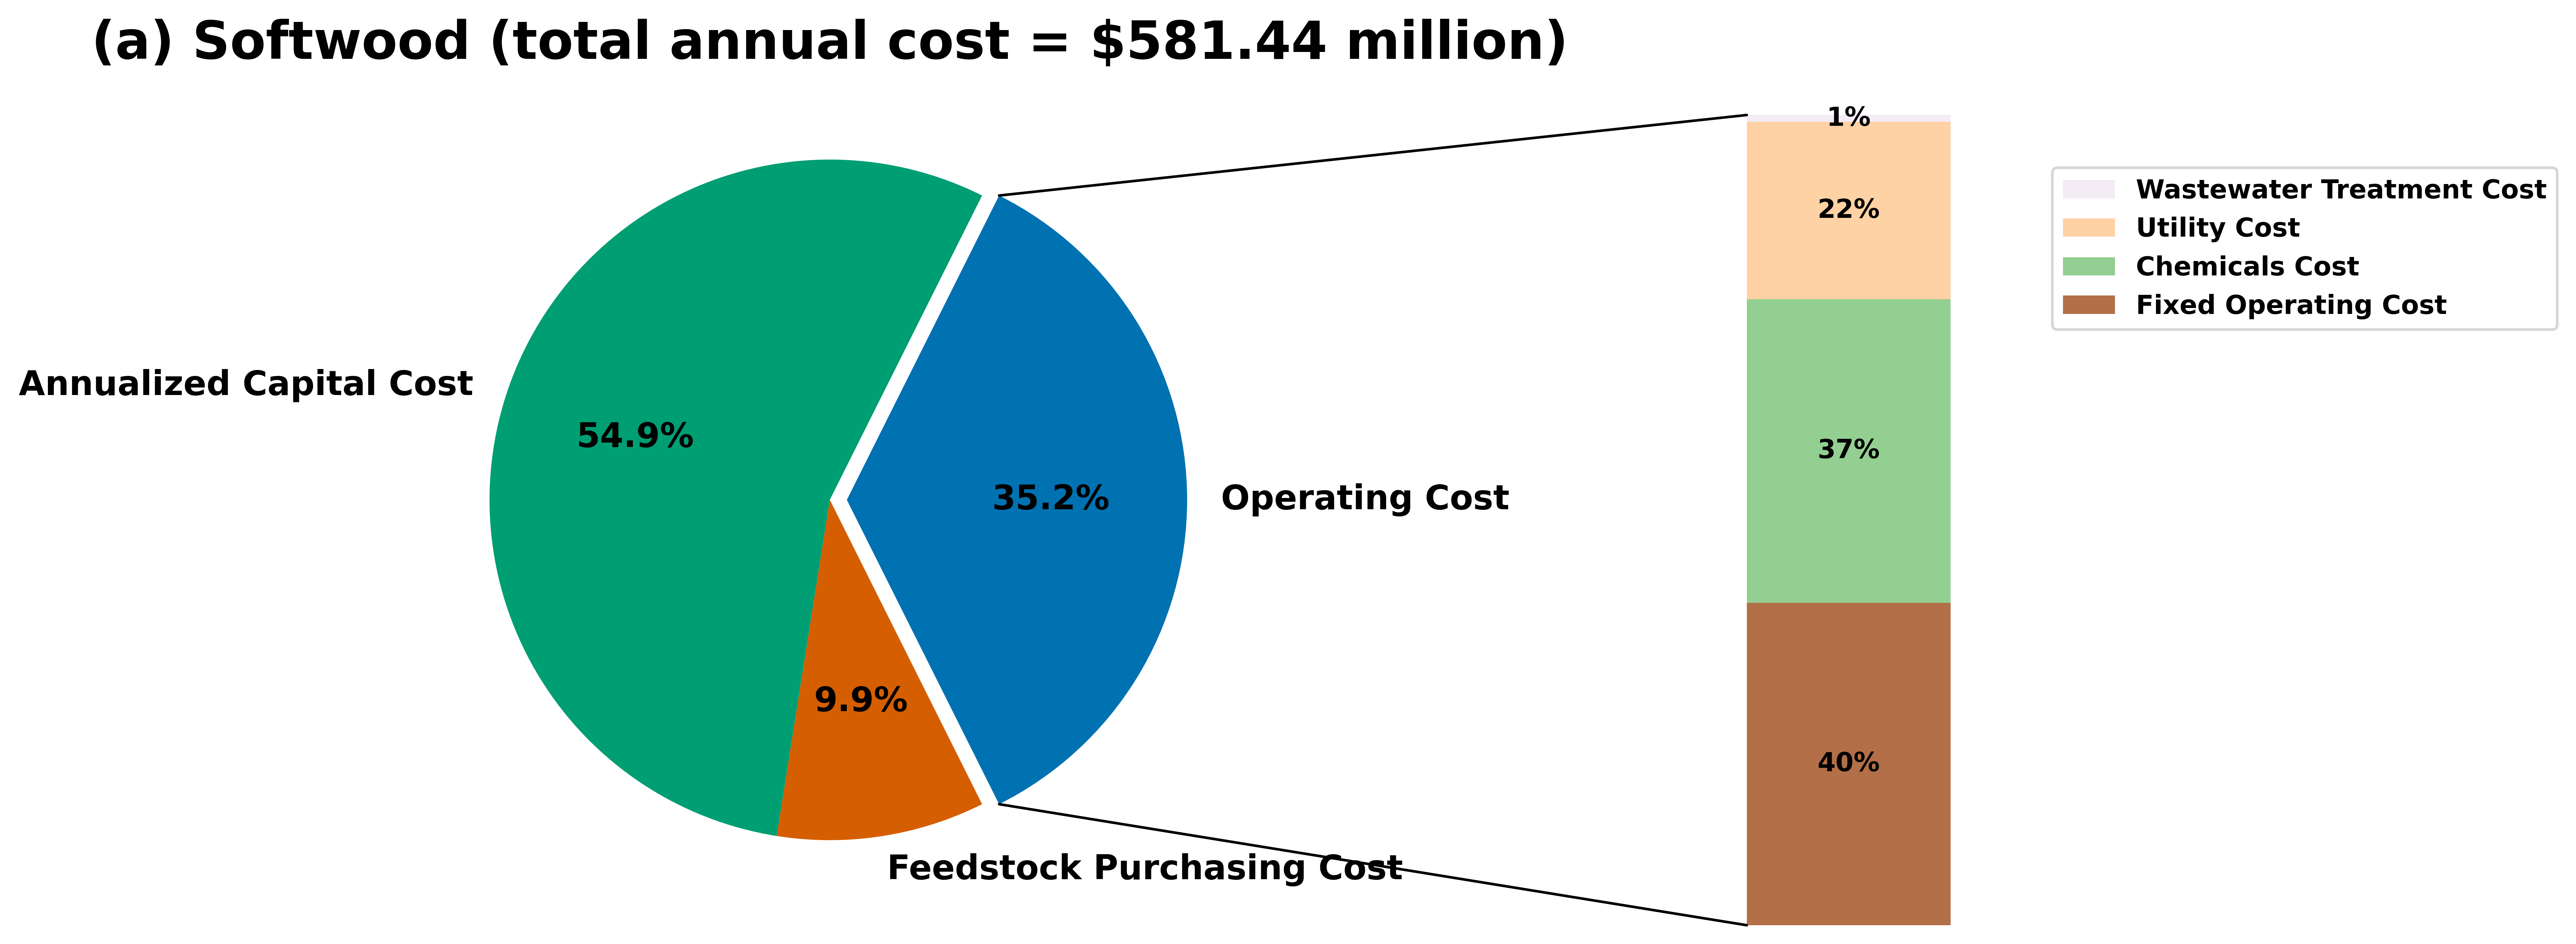

In [92]:
plt.style.use('seaborn-colorblind')
# sns.set_palette('deep')

plt.rcParams['font.weight'] = 'bold'

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6),dpi=600)

fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = [OPEX()*days/total, CAPEX()*1000000* ir / (1-(1/(1+ir)**n))/total, feedstock_cost()*days/total]
labels = ['Operating Cost','Annualized Capital Cost','Feedstock Purchasing Cost']
explode = [0.05, 0, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * overall_ratios[0]
wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                     labels=labels, explode=explode,textprops={'fontsize': 13})

# bar chart parameters
age_ratios = [FOC()/OPEX(), chemical_cost()/OPEX(),utility_cost()/OPEX(), Cw/OPEX()]
age_labels = ['Fixed Operating Cost',
              'Chemicals Cost',
              'Utility Cost',
              'Wastewater Treatment Cost']
bottom = 1
width = 3

# Color-blind friendly palette
colors = [ '#984ea3', '#ff7f00', '#4daf4a', '#a65628']

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom,label=label,color=colors[j],
                 alpha=0.1 + 0.25 * j)
    ax2.text(0, bottom + height/2, f"{height:.0%}", ha='center', va='center')


#ax2.set_title('Operating cost composition')
ax2.legend(loc=(0.7,0.7))
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(age_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(1)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(1)

ax1.set_title(f'(a) Softwood (total annual cost = ${total/1e6:.2f} million)', x=0.5, y=1, weight='bold', size=20)

In [93]:
plt.style.use('seaborn-colorblind')
# sns.set_palette('deep')

plt.rcParams['font.weight'] = 'bold'

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6),dpi=600)

fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = [OPEX()*days/total, CAPEX()*1000000* ir / (1-(1/(1+ir)**n))/total, feedstock_cost()*days/total]
labels = ['Operating Cost','Annualized Capital Cost','Feedstock Purchasing Cost']
explode = [0.05, 0, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * overall_ratios[0]
wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                     labels=labels, explode=explode,textprops={'fontsize': 20})

# bar chart parameters
age_ratios = [FOC()/OPEX(), chemical_cost()/OPEX(),utility_cost()/OPEX(), Cw/OPEX()]
age_labels = ['Fixed Operating Cost',
              'Chemicals Cost',
              'Utility Cost',
              'Wastewater Treatment Cost']
bottom = 1
width = 3

# Color-blind friendly palette
colors = [ '#984ea3', '#ff7f00', '#4daf4a', '#a65628']

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom,label=label,color=colors[j],
                 alpha=0.1 + 0.25 * j)
    ax2.text(0, bottom + height/2, f"{height:.0%}", ha='center', va='center',fontsize=20)


#ax2.set_title('Operating cost composition')
ax2.legend(loc=(0.7,0.7),fontsize=20)
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(age_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(1)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(1)

ax1.set_title(f'Total annual cost =${total/1e6:.2f} million', x=0.5, y=1, weight='bold', size=20)

<ipython-input-93-40fa80c6c2d5>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


Text(0.5, 1, 'Total annual cost =$581.44 million')

#### Only annual

(-1.0999992929622207,
 1.0999993020453385,
 -1.0999995999499954,
 1.0999999809499998)

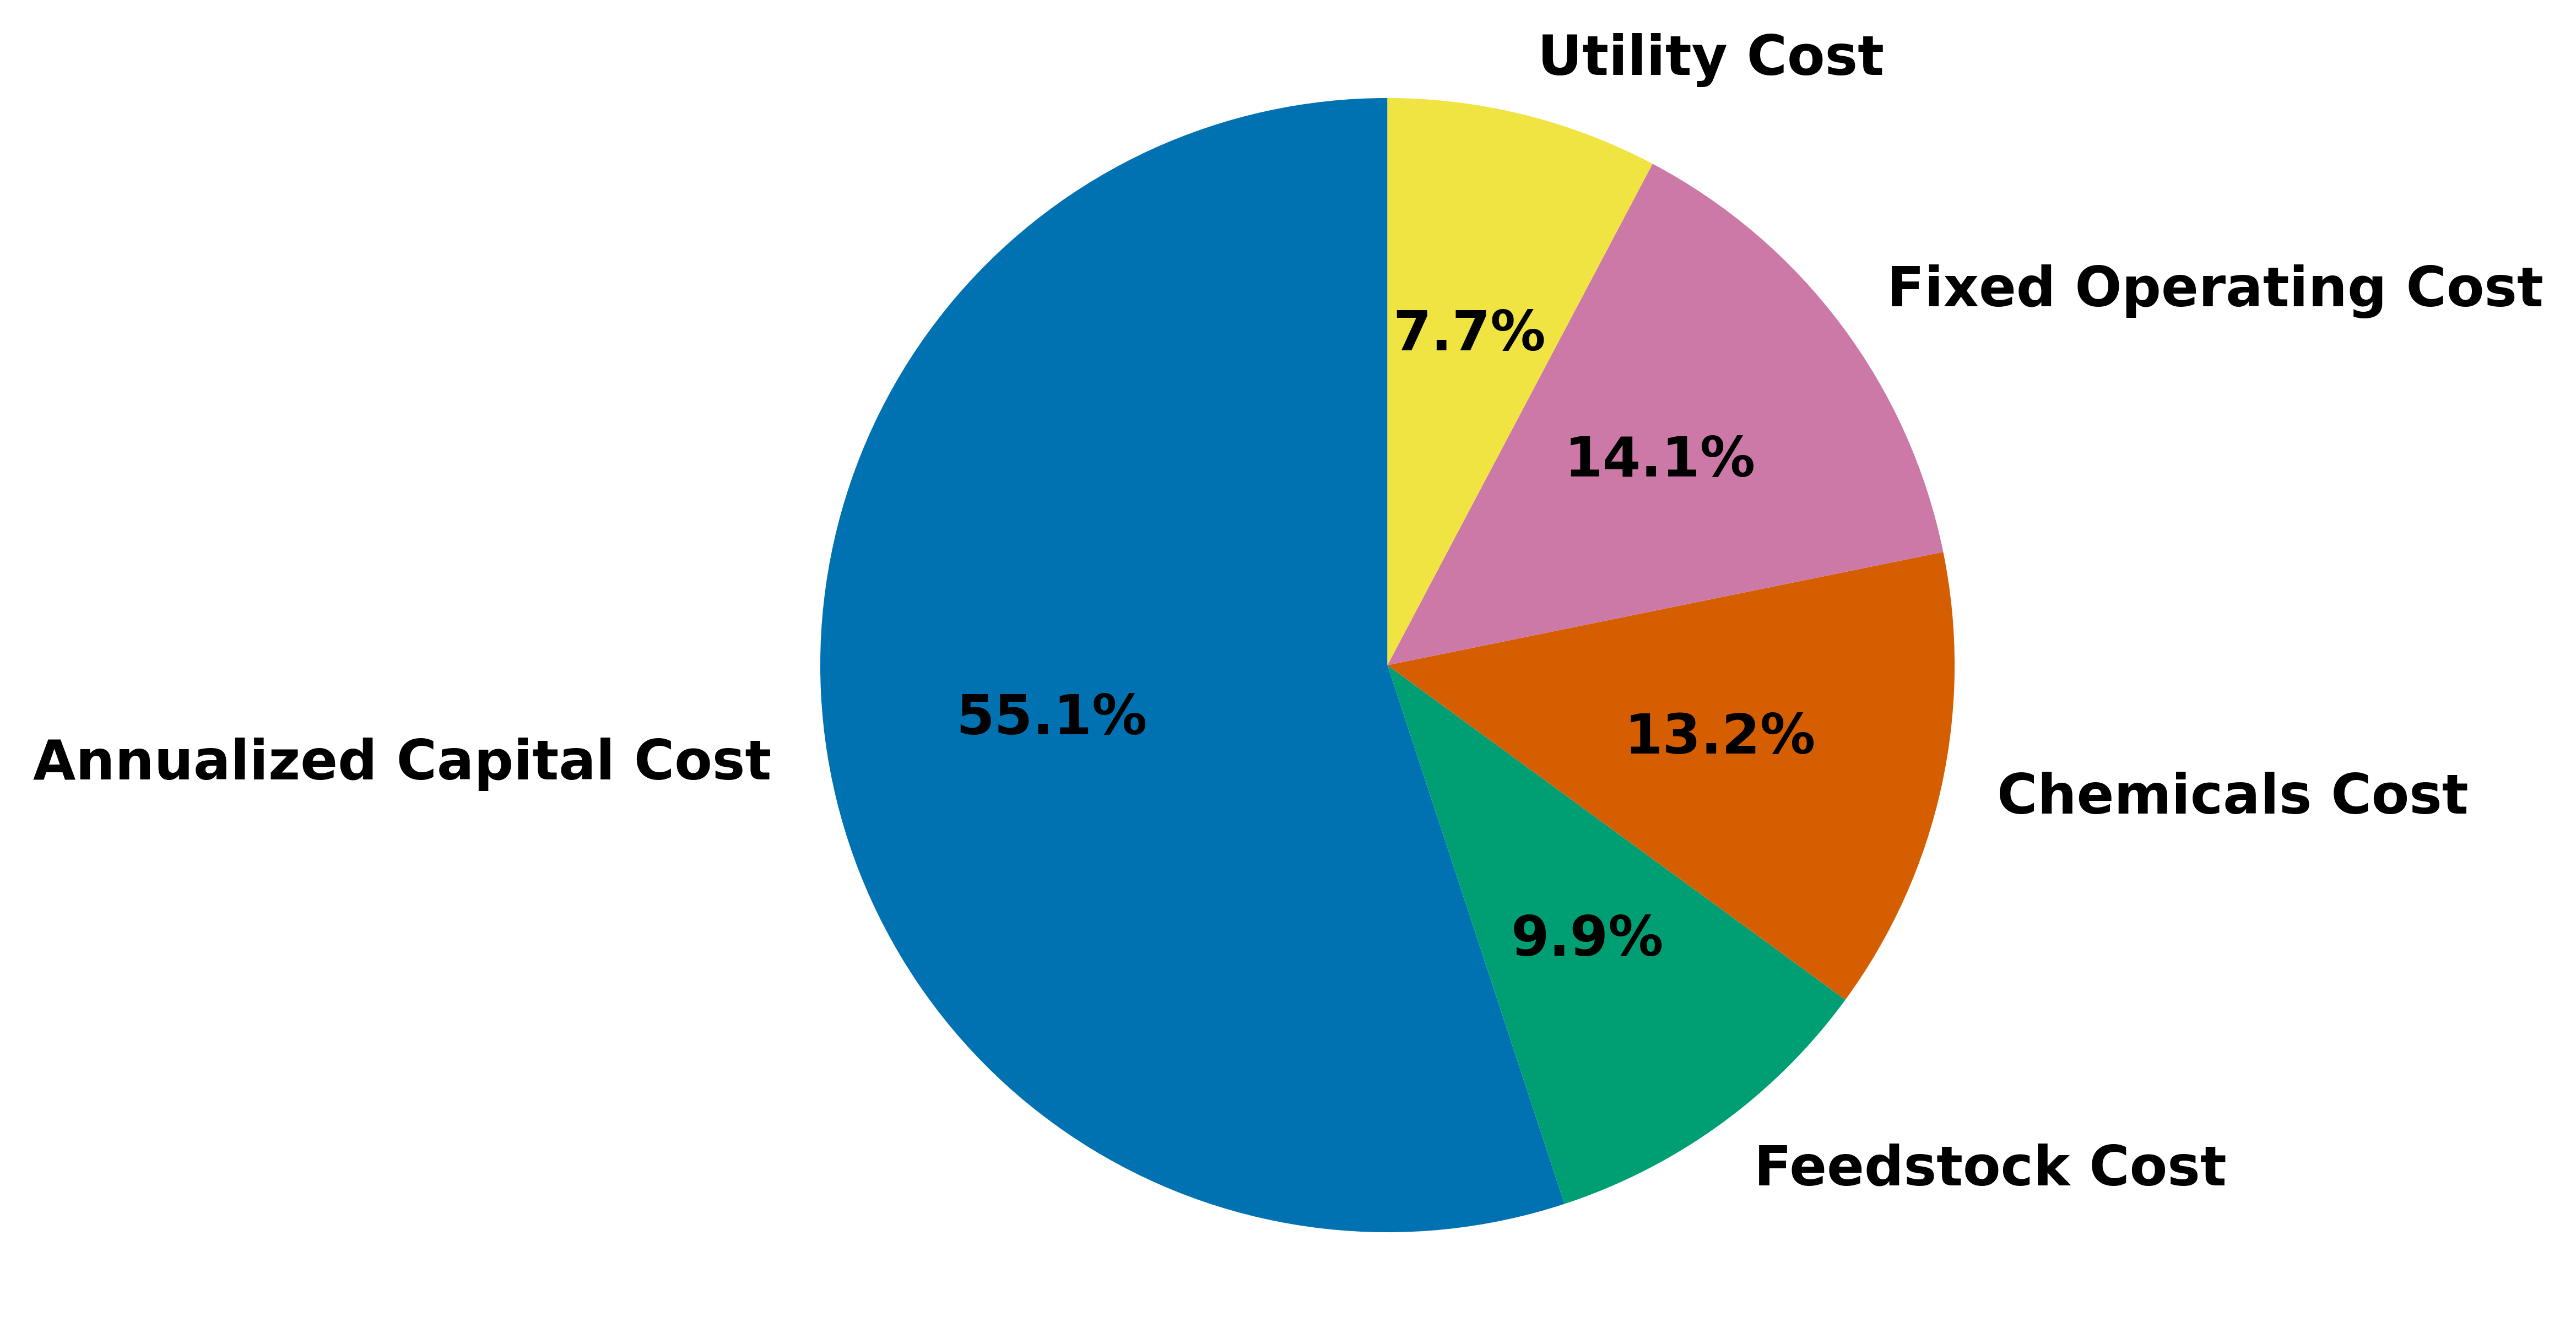

In [94]:
labels = 'Annualized Capital Cost','Feedstock Cost','Chemicals Cost','Fixed Operating Cost','Utility Cost'
sizes = [CAPEX()*1000000* ir / (1-(1/(1+ir)**n))/total,feedstock_cost()*330/total,
         chemical_cost()*330/total,FOC()*330/total,utility_cost()*330/total]
explode = (0, 0, 0, 0,0) 

fig1, ax1 = plt.subplots(figsize=(8,5),dpi=600)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90,textprops={'fontsize': 12})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#### Cost at each stage

### Revenue composition

<ipython-input-95-01db94c875b3>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


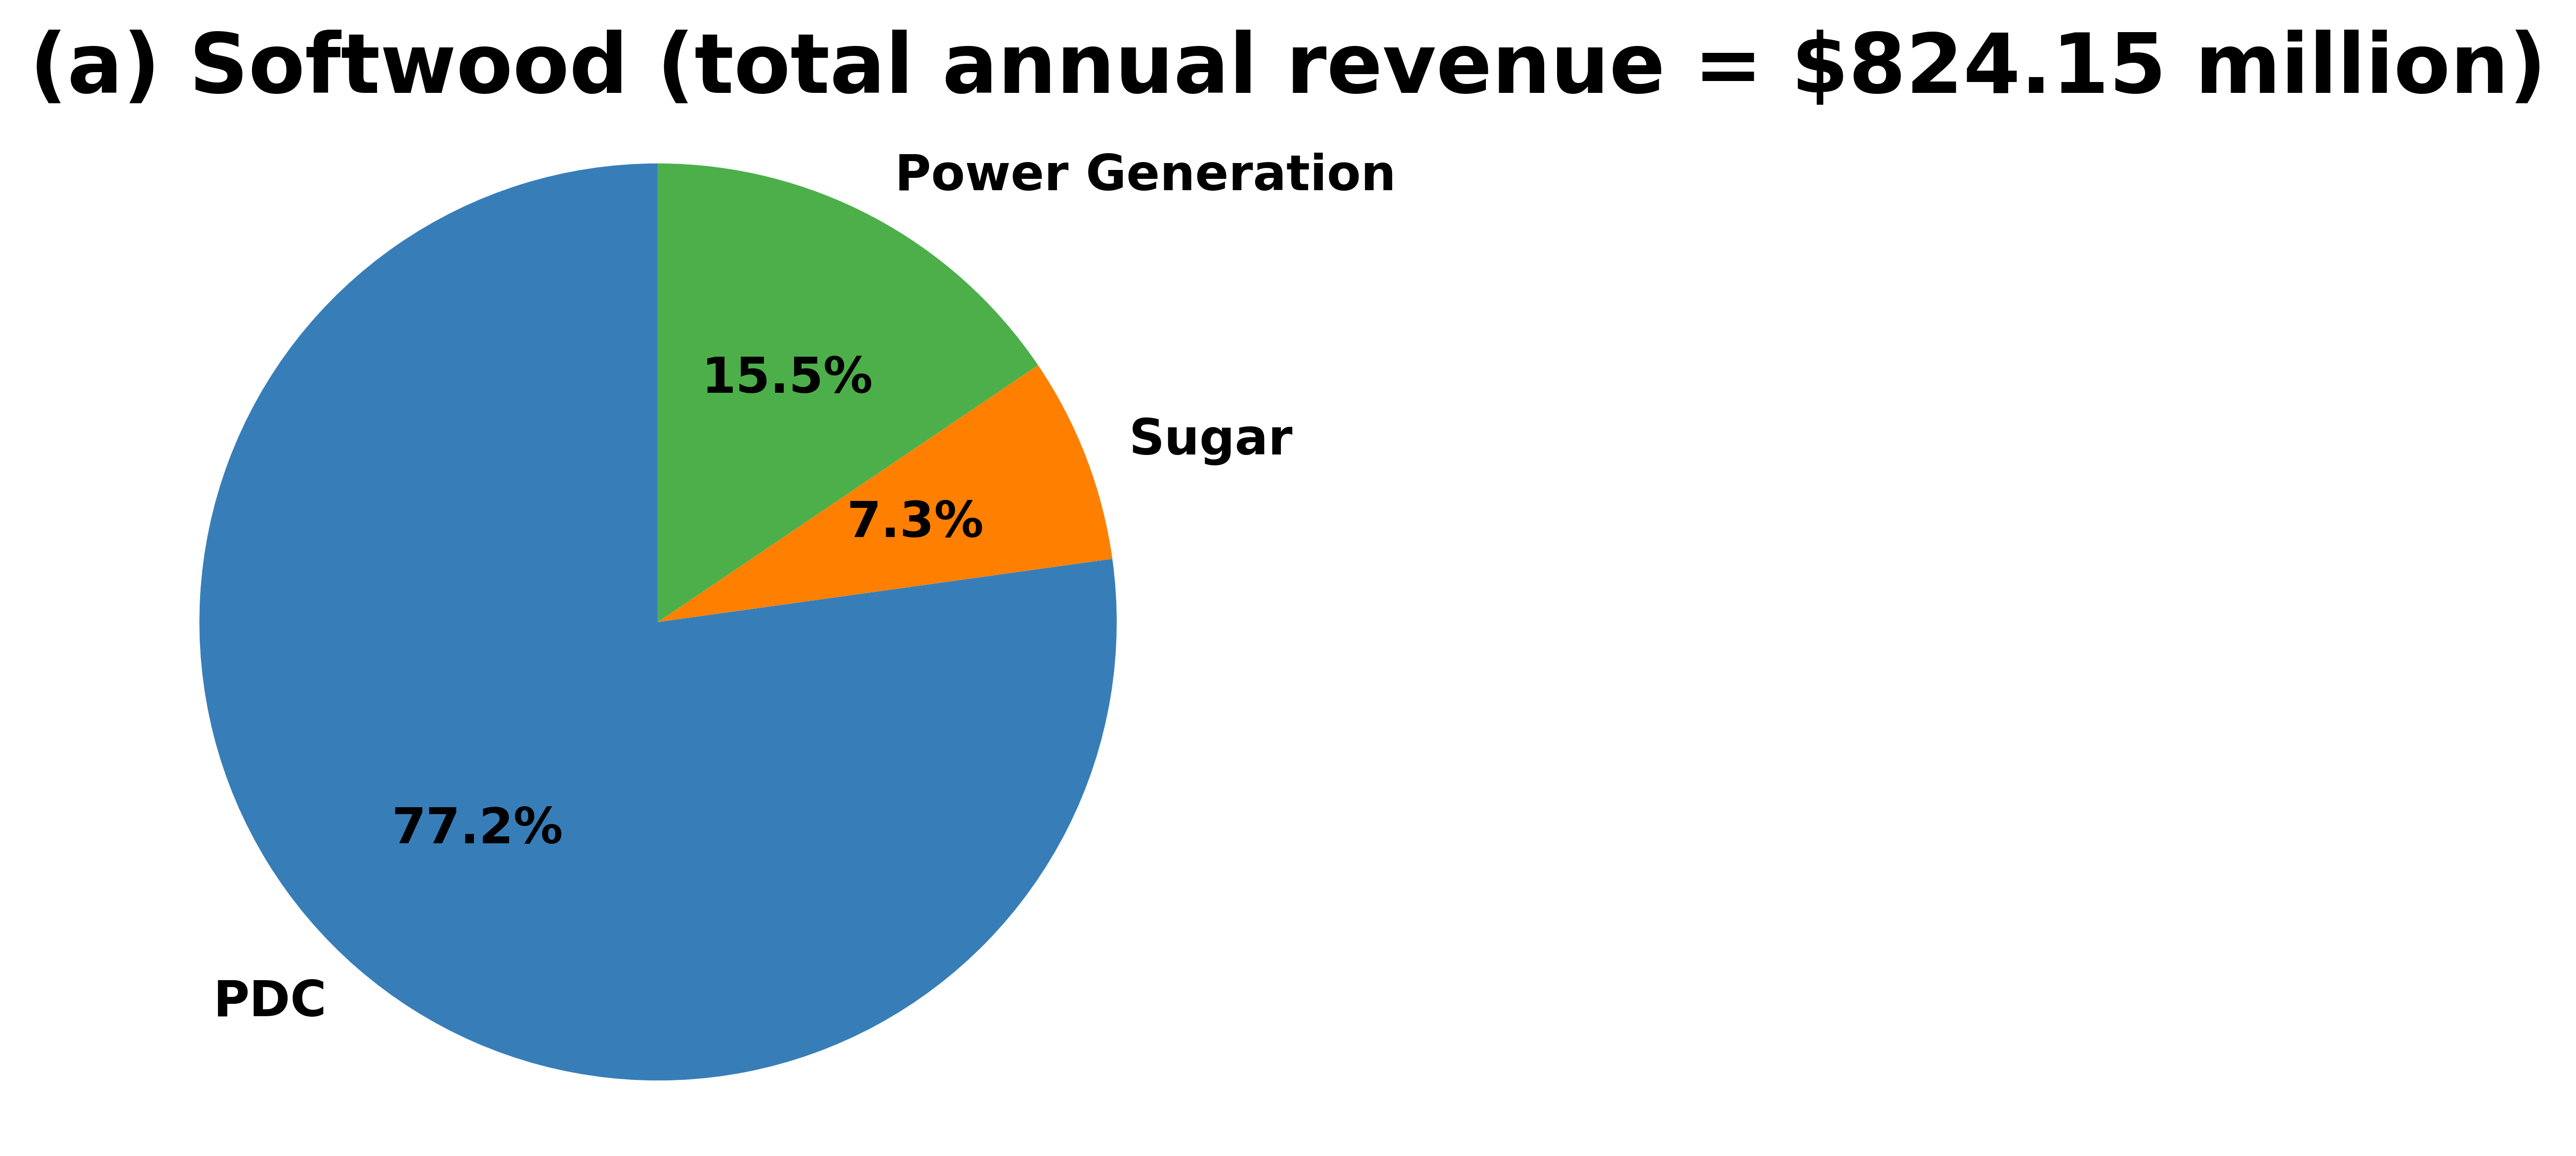

In [95]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.weight'] = 'bold'

# figsize and dpi are modified to maintain consistency.
fig1, ax1 = plt.subplots(figsize=(5, 4), dpi=600)  # Adjusted size and resolution
colors = ['#377eb8', '#ff7f00', '#4daf4a']  # Color-blind friendly palette

sizes = [
    revenue_final_product(),
    revenue_coproduct_glucose() + revenue_coproduct_xylose(),
    revenue_BOTU()
]
explode = (0, 0, 0)  # Exploding the first slice like in the second chart
labels = ['PDC', 'Sugar', 'Power Generation']

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors,
        textprops={'fontsize': 12, 'weight': 'bold'})  # Adjusted fontsize and fontweight
ax1.axis('equal')

ax1.set_title(f'(a) Softwood (total annual revenue = ${AR()*days/1e6:.2f} million)', loc='left', weight='bold', size=20)  # Consistent title properties
fig1.tight_layout()

<ipython-input-96-746c607a4138>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


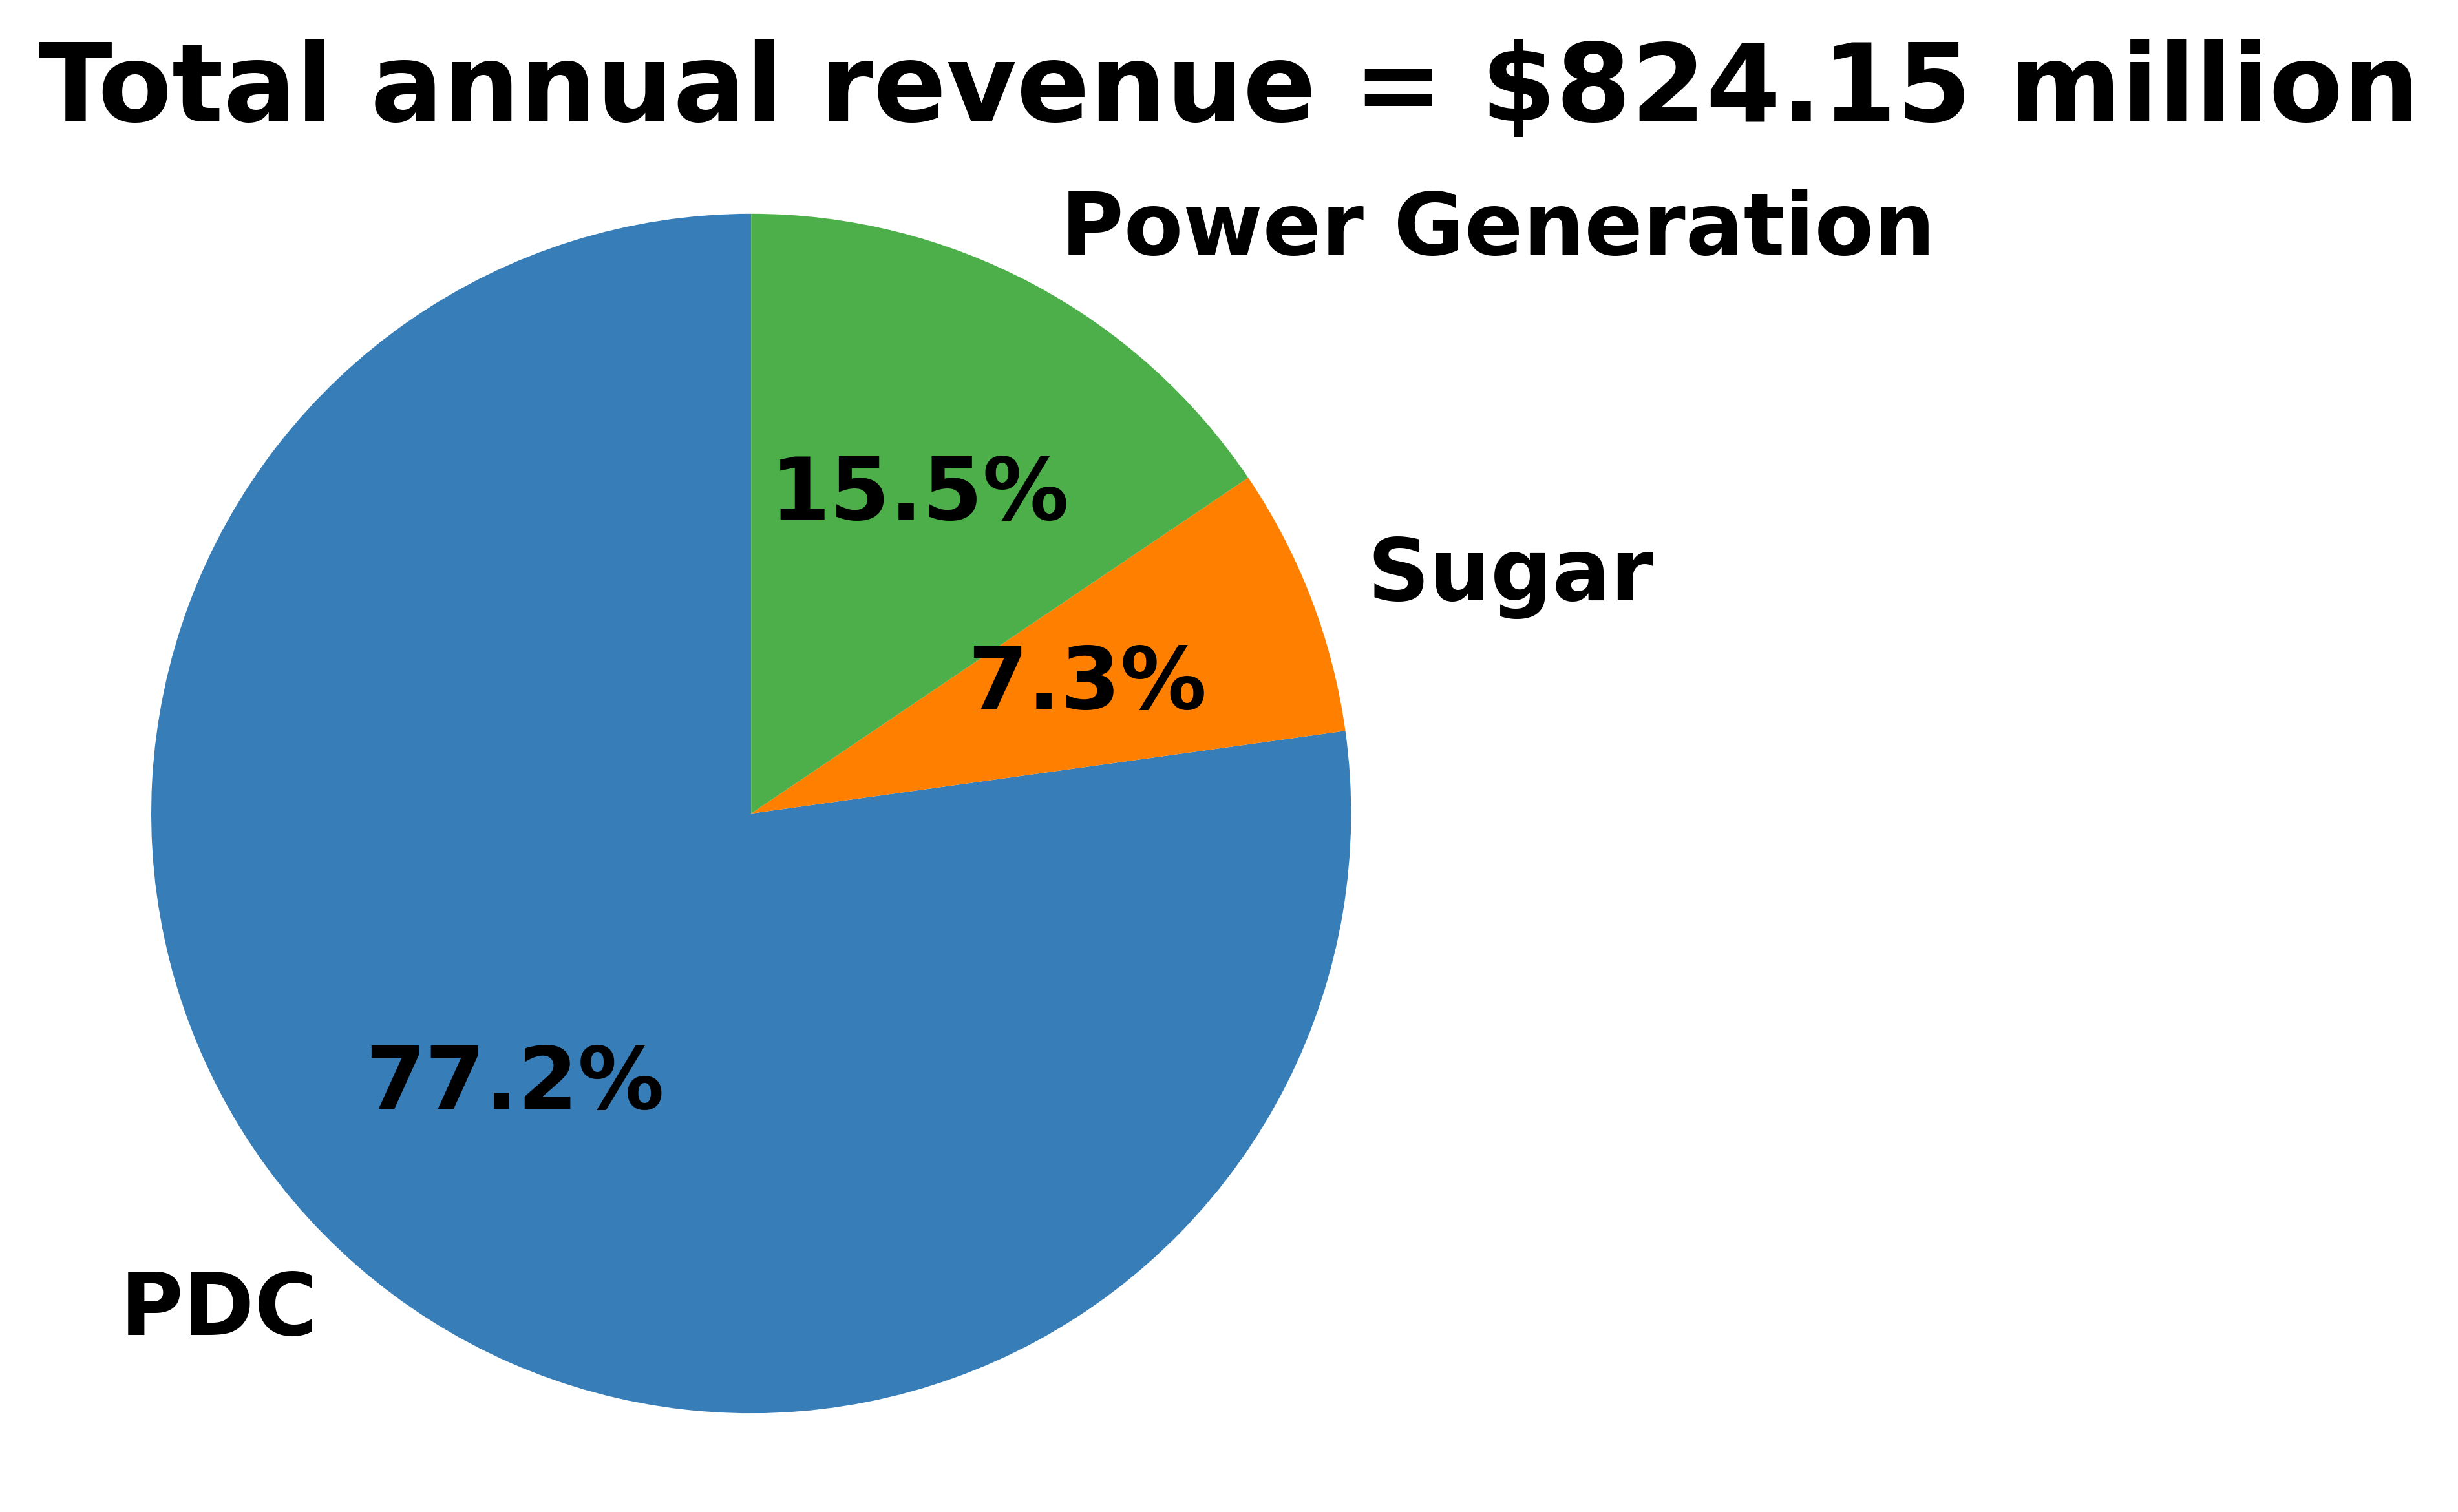

In [96]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.weight'] = 'bold'

# figsize and dpi are modified to maintain consistency.
fig1, ax1 = plt.subplots(figsize=(5, 4), dpi=600)  # Adjusted size and resolution
colors = ['#377eb8', '#ff7f00', '#4daf4a']  # Color-blind friendly palette

sizes = [
    revenue_final_product(),
    revenue_coproduct_glucose() + revenue_coproduct_xylose(),
    revenue_BOTU()
]
explode = (0, 0, 0)  # Exploding the first slice like in the second chart
labels = ['PDC', 'Sugar', 'Power Generation']

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors,
        textprops={'fontsize': 16, 'weight': 'bold'})  # Adjusted fontsize and fontweight
ax1.axis('equal')

ax1.set_title(f'Total annual revenue = ${AR()*days/1e6:.2f} million', loc='left', weight='bold', size=20)  # Consistent title properties
fig1.tight_layout()

<ipython-input-97-7131aaed0d6c>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')
<ipython-input-97-7131aaed0d6c>:71: UserWarning: The figure layout has changed to tight
  fig1.tight_layout()


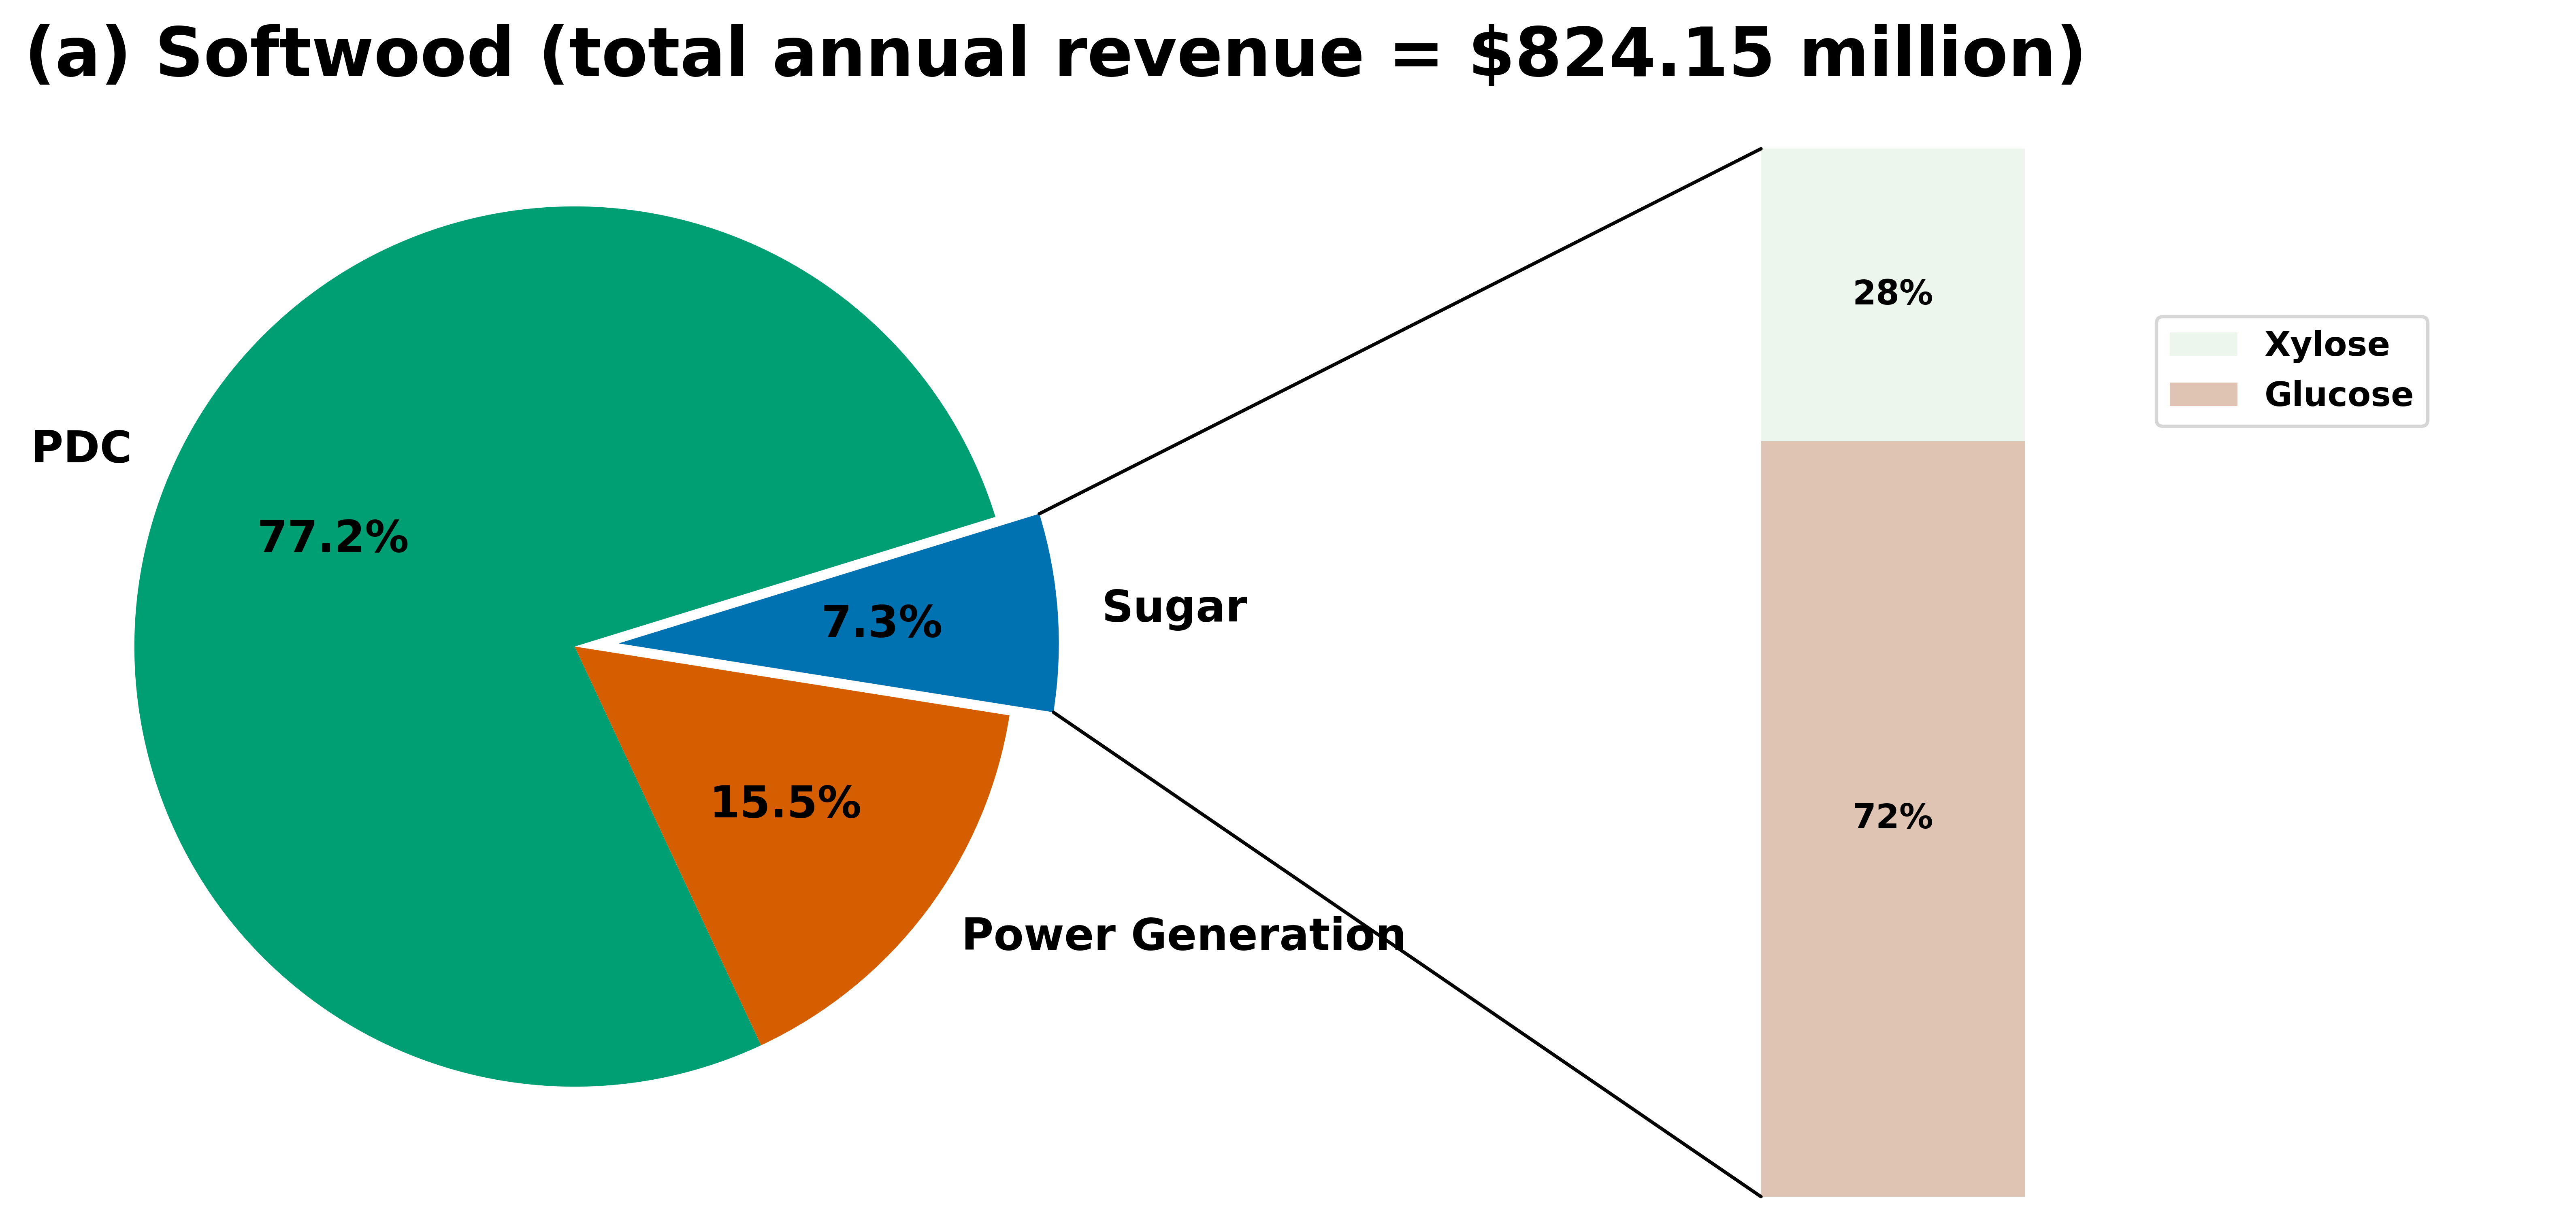

In [97]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.weight'] = 'bold'

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6),dpi=600)
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = [revenue_coproduct_glucose() + revenue_coproduct_xylose(),
                  revenue_final_product(),
                  revenue_BOTU()]


explode = (0.1, 0, 0)  # Exploding the first slice like in the second chart
labels = [ 'Sugar', 'PDC','Power Generation']


# rotate so that first wedge is split by the x-axis
angle = -180 * overall_ratios[0] - 45
wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                     labels=labels, explode=explode,textprops={'fontsize': 13})

# bar chart parameters
age_ratios = [revenue_coproduct_glucose()/(revenue_coproduct_glucose() + revenue_coproduct_xylose()), 
              revenue_coproduct_xylose()/(revenue_coproduct_glucose() + revenue_coproduct_xylose())]
age_labels = ['Glucose',
              'Xylose']
bottom = 1
width = 3

# Color-blind friendly palette
colors = [ '#4daf4a', '#a65628']

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom,label=label,color=colors[j],
                 alpha=0.1 + 0.25 * j)
    ax2.text(0, bottom + height/2, f"{height:.0%}", ha='center', va='center')


#ax2.set_title('Operating cost composition')
ax2.legend(loc=(0.7,0.7))
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(age_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(1)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(1)

ax1.set_title(f'(a) Softwood (total annual revenue = ${AR()*days/1e6:.2f} million)', loc='left', weight='bold', size=20)  # Consistent title properties
fig1.tight_layout()

### Material flow

In [98]:
import plotly.graph_objects as go
import urllib, json

In [99]:
url = 'https://raw.githubusercontent.com/plotly/plotly.js/master/test/image/mocks/sankey_energy.json'
response = urllib.request.urlopen(url)
data = json.loads(response.read())

In [100]:
print("fractionation inflow cellulose amount",model.Finfr['alkaline','cellulose'].value)
print("fractionation inflow hemicellulose amount",model.Finfr['alkaline','hemicellulose'].value)
print("fractionation inflow lignin amount",model.Finfr['alkaline','lignin1'].value)
print("fractionation outflow glucose amount",model.Foutfr['alkaline','glucose'].value)
print("fractionation outflow xylose amount",model.Foutfr['alkaline','xylose'].value)
print("fractionation outflow lignin amount",model.Foutfr['alkaline','lignin2'].value)

print("fractionation outflow lignin to burn amount",model.Fburnfr['alkaline','lignin1'].value)
print("fractionation outflow unconverted cellulose to burn amount",model.Fburnfr['alkaline','cellulose'].value)
print("fractionation outflow unconverted hemicellulose to burn amount",model.Fburnfr['alkaline','hemicellulose'].value)

print("outflow PDC amount",model.Fout['PDC-ferm'].value)

fractionation inflow cellulose amount 760.0
fractionation inflow hemicellulose amount 640.0
fractionation inflow lignin amount 600.0
fractionation outflow glucose amount 281.2
fractionation outflow xylose amount 108.80000000000001
fractionation outflow lignin amount 282.0
fractionation outflow lignin to burn amount 318.0
fractionation outflow unconverted cellulose to burn amount 478.79999999999995
fractionation outflow unconverted hemicellulose to burn amount 531.1999999999999
outflow PDC amount 250.98


In [101]:
F_BU_total = model.Fburnfr['alkaline','cellulose'].value\
            + model.Fburnfr['alkaline','hemicellulose'].value\
            + model.Fburnfr['alkaline','lignin1'].value\
            + model.Foutdpl['BCD','unconverted-lignin'].value

In [102]:
# Assuming you have all the model values defined somewhere in your code
# Add a color for each of your nodes
node_colors = [
    "green",  # feedstock
    "#15DFB0", # cellulose
    "#1595DF", # hemicellulose
    "#663300", # lignin
    "#999900",# glucose
    "#006633",# xylose
    "purple",  # lignin monomers
    "#202020",# unconverted cellulose
    "#404040",# unconverted hemicellulose
    "grey",# unconverted lignin
    "#0D7AE8",  # PDC
    "red",   # Boiler/Turbogenerator
    "#FF3333" # Electricity generation
]
  
# Create a list of original labels
original_labels = [
    "feedstock", #0
    "cellulose", "hemicellulose", "lignin", #1,2,3
    "glucose", "xylose", # 4,5
    "unconverted cellulose", "unconverted hemicellulose", "unconverted lignin", #6,7,8
    "lignin monomers", #9
    'PDC',#10
    'Boiler/Turbogenerator', #11
    'Electricity generation' #12
]

# Extracting the values
values = [
    model.Fin['alkaline'].value,
    model.Finfr['alkaline', 'cellulose'].value,
    model.Finfr['alkaline', 'hemicellulose'].value,
    model.Finfr['alkaline', 'lignin1'].value,
    model.Foutfr['alkaline', 'glucose'].value,
    model.Foutfr['alkaline', 'xylose'].value,
    model.Fburnfr['alkaline', 'cellulose'].value,
    model.Fburnfr['alkaline', 'hemicellulose'].value,
    model.Fburnfr['alkaline', 'lignin1'].value,
    model.Findpl['noprocess', 'lignin2'].value,
    model.Fout['PDC-ferm'].value,
    model.Fburnfr['alkaline', 'cellulose'].value+model.Fburnfr['alkaline', 'hemicellulose'].value+model.Fburnfr['alkaline', 'lignin1'].value,
    Fout_BOTU()/1000
]

# Create a new list of labels with the corresponding units
new_labels = [f"{label}<br>({round(value, 2)} {'MWh/day' if label == 'Electricity generation' else 'MT/day'})" 
              for label, value in zip(original_labels, values)]

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=18,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=new_labels,  # Updated labels
        color=node_colors  # Using the predefined color list
    ),
    link=dict(
        source=[0, 0, 0, 1, 2, 3, 1, 2, 3, 9, 6,  7,  8, 11],
        target=[1, 2, 3, 4, 5, 9, 6, 7, 8, 10,11, 11, 11,12],
        value=[
            model.Finfr['alkaline', 'cellulose'].value,
            model.Finfr['alkaline', 'hemicellulose'].value,
            model.Finfr['alkaline', 'lignin1'].value,
            model.Foutfr['alkaline', 'glucose'].value,
            model.Foutfr['alkaline', 'xylose'].value,
            model.Foutfr['alkaline', 'lignin2'].value,
            model.Fburnfr['alkaline', 'cellulose'].value,
            model.Fburnfr['alkaline', 'hemicellulose'].value,
            model.Fburnfr['alkaline', 'lignin1'].value,
            model.Fout['PDC-ferm'].value,
            model.Fburnfr['alkaline', 'cellulose'].value,
            model.Fburnfr['alkaline', 'hemicellulose'].value,
            model.Fburnfr['alkaline', 'lignin1'].value,
            0.43*(model.Fburnfr['alkaline', 'cellulose'].value+model.Fburnfr['alkaline', 'hemicellulose'].value\
                  +model.Fburnfr['alkaline', 'lignin1'].value)
        ]  
    )
)])

fig.update_layout(
    title_text="(a) Softwood", 
    title_x=0, 
    title_font=dict(size=20, color='black')
)

fig.show()